## Backup Reminder : DO IT!

In [1]:
# All the necessary imports
import actr
import pickle
import random
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import groupby

In [2]:
help(actr)

## Experiment Logs
    - 10th June 2020: 06:50am
        - Testing the plotting function.
        - Backing up the code to github: Done
        

## Control Flow Logs
    - Flow of the program in simple words
        -Need to understand the ACT-R Model first 
    - Data Structures, their shapes and the purpose of their existence

#### Word lists do not contain actual words?
    No they don't, we will do this in later experiment
#### Number of words in each list i.e. list_length should be n where (n-2)%3 == 0 because 2 neutral words are added in each list.

#### The adjustable parameters in this experiment code.
    - Number of lists
    - Number of words in each list
    - The time taken for rehearsal (6 + delay of .5 seconds) and recall(10)
#### Adjustable parameters in ACT-R
    - :declarative-num-finsts 21 ; number of items that are kept as recently retrieved (Change it to 5) 
    - :declarative-finst-span 21 ; how long items stay in the recently-retrieved state (5,100)

In [3]:
### Experiment part ###

subject = ''

current_list = ''

recalled_words = defaultdict(list)

rehearsed_words =  defaultdict(lambda: defaultdict(int))

list_amount = 1    # No of lists

list_length = 83    # No of words in a list

rehearsal_time = 6  # No of seconds for which rehearsal happens and each word is shown

delay = 0.1  #delay between rehearsal and recall

recall_time = 10 

In [4]:
word_lists_dict = defaultdict(list)

# Ensure there are enough unique words to create the word lists
word_dict = {"positive": ["positive" + str(i) for i in range(999)],
             "negative": ["negative" + str(i) for i in range(999)],
             "neutral": ["neutral" + str(i) for i in range(999)]}

In [5]:
def add_words(i, list_length):
    '''
    Add the words to the word lists, ensures valence categories are balanced
    '''
    global word_lists_dict

    amnt_wanted = (list_length -2)/3   # Amount of each valence wanted, minus 2 neutrals controlling for primacy
    amt_positive, amt_negative, amt_neutral, count = 0, 0, 0, 0
    while len(word_lists_dict[i]) != list_length:
        count += 1
        #print(f"...................{count,word_lists_dict[i]}")
        if count >= 9999: # IF it takes too long to create a unique list at random, start over
            word_lists_dict[i] = []
            add_words(i, list_length)
        if len(word_lists_dict[i]) == 0: # Place two neutral words at the start to control for primacy effects
            word_to_add1 = word_dict["neutral"][random.randint(0, len(word_dict["neutral"])-1)]
            word_to_add2 = word_dict["neutral"][random.randint(0, len(word_dict["neutral"])-1)]
            if word_to_add1 not in word_lists_dict[i] and word_to_add2 not in word_lists_dict[i] and word_to_add1 != word_to_add2:
                word_lists_dict[i].append(word_to_add1)
                word_lists_dict[i].append(word_to_add2)
            else:
                continue # skip this loop iteration                   
        else: 
            random_valence = random.choice(["positive", "negative", "neutral"])
            word_to_add = word_dict[random_valence][random.randint(0, len(word_dict[random_valence])-1)]
            if word_to_add not in word_lists_dict[i] and word_lists_dict[i][-1] not in word_dict[random_valence] and \
               amt_positive <= amnt_wanted and amt_negative <= amnt_wanted and amt_neutral <= amnt_wanted:
                if random_valence == "positive" and amt_positive < amnt_wanted:
                    amt_positive += 1
                elif random_valence == "negative" and amt_negative < amnt_wanted:
                    amt_negative +=1
                elif random_valence == "neutral" and amt_neutral < amnt_wanted:
                    amt_neutral +=1
                else:
                    continue # skip this loop iteration
                word_lists_dict[i].append(word_to_add)

In [6]:
def create_lists(list_amount=3, list_length=2):
    '''
    Create the wordlists used during the free recall tasks 
    '''  
    global word_lists_dict 

    for i in range(list_amount):
        print(f'List {i+1}/{list_amount} created!', end="\r")
        add_words(i, list_length)

    # Save the dictionary to a .pickle file, so we do not have to create the word lists everytime we run the model                    
    file = open(f"word_lists\word_lists_dict_{list_length}_{list_amount}.pickle","wb")
    pickle.dump(word_lists_dict, file)
    file.close()
    return word_lists_dict

In [7]:
# Check if the word lists already exist, else create new word lists
try:
    file = open(f"word_lists\word_lists_dict_{list_length}_{list_amount}.pickle","rb")
    #file = open(f"word_lists_dict_100_items_only.pickle","rb")
    word_lists_dict = pickle.load(file)  
    file.close()
    print("\nSuccesfully loaded the word lists!\n")
except FileNotFoundError:
    print("\nCreating word lists!\n")
    #amount_to_create = list_amount                              
    word_lists_dict = create_lists(list_amount,list_length)


Succesfully loaded the word lists!



In [8]:
def display_word_lists():
    '''
    Display the word lists loaded/created
    '''
    for key, value in word_lists_dict.items():
        print(f'List {key}:\n {value}\n')

def close_exp_window():
    '''
    Close opened ACT-R window
    '''
    return actr.current_connection.evaluate_single("close-exp-window")

In [9]:
def prepare_for_recall(): 
    '''
    Disable rehearsing productions, and clearing buffer contents to start the recalling phase 
    '''
    disable_list = ["rehearse-first", "rehearse-second", "rehearse-third", "rehearse-fourth", 
                    "rehearse-it", "skip-first", "skip-second", "skip-third", "skip-fourth"]
    for prod in disable_list:
        actr.pdisable(prod)
    actr.run(1, False) 
    for buff in ["imaginal", "retrieval", "production"]:
        actr.clear_buffer(buff)  

In [10]:
def setup_dm(word_list):
    '''
    Add words to declarative memory, since it can be assumed the test subjects know the English language already
    '''
    #print("\n\n############################################# Inside setup_dm i.e. Declarative Memory")
     
    colour_conversion = {'pos': 'GREEN', 'neg': 'RED', 'neu': 'BLACK'}
    for idx, word in enumerate(word_list):
        valence = ''.join([char for char in word if not char.isdigit()])[:3]
        actr.add_dm(('item'+str(idx), 'isa', 'memory', 'word', "'"+word+"'", 'valence', colour_conversion[valence]))
#         if idx == 0:
#             print("\n Emaple of a chunk added in Declarative Memory is \n")
#             print('item'+str(idx), 'isa', 'memory', 'word', "'"+word+"'", 'valence', colour_conversion[valence],"\n")
        

In [11]:
def setup_experiment(human=True):
    '''
    Load the correct ACT-R model, and create a window to display the words
    '''
#     print("\n\n############################################# Inside setup_experiment")
#     print(f'\nSubject = {subject}\n')  

    loaded = None
    if subject == "controls":
        #loaded = actr.load_act_r_model(r"C:\Users\cleme\Documents\Education\RUG\First-Year_Research\My_Project\Model\models\free_recall_regular_v1.lisp")
        loaded = actr.load_act_r_model(r"C:\Users\cleme\Documents\Education\RUG\First-Year_Research\My_Project\Model\models\csm_free_recall_model.lisp")
    elif subject == "depressed":
        loaded = actr.load_act_r_model(r"C:\Users\cleme\Documents\Education\RUG\First-Year_Research\My_Project\Model\models\csm_free_recall_model_depressed.lisp")
    
    #print("\n\n############################################# Inside setup_experiment")
    #print(f'\nLoaded Act-r model = {loaded}\n')  



    window = actr.open_exp_window("Free Recall Experiment", width=1024, height=768, visible=human) # 15inch resolution window
    actr.install_device(window) 
    return window    

In [12]:
def record_words_recalled(item):
    '''
    Register which words were recalled during the experiment for a specific wordlist and strip the numbers
    '''
    valence = ''.join(char for char in item if not char.isdigit())
    item_idx = ''.join(char for char in item if char.isdigit())
    recalled_words[current_list].append((valence, item_idx))
   

In [13]:
def create_result_dict():
    '''
    Use a module-level function, instead of lambda function, to enable pickling it
    '''
    return defaultdict(int)

In [14]:
def record_words_rehearsed(item):
    '''
    Register amount of rehearsals per word for each wordlist
    '''
    rehearsed_words[current_list][item] += 1

# Testing Creation of Plots which involves testing
    - create_lplot(idx, xlabel, ylabel, x, y, xticks_len, filename, ytick_range=None, show=False)
    - analysis(wlist_amount, show_plots=False)

In [15]:

def create_lplot(idx, xlabel, ylabel, x, y, xticks_len, filename, ytick_range=None, show=False):
    '''
    Create line plot using matplotlib
    Args:
        Input:
            -idx: The id of the type of plot to be made.
                  0: Rehearse Freuency
                  1: Starting Recall
                  2: Recall Probability
            -xlabel: Label for x-axis of the plot (Serial Input Position for this experiment).
            -ylabel: Label for y-axis of the plot (One of idx 0,1 or 2).
            -x: Serial Input Positions which depends on the length of the words list ex: range(1,20).
                shape: (1, list_length)
            -y: Values for the idx 0,1 or 2.
                shape: (list_length,)
            -xticks_len: length for ticks on x-axis, same as len(x)
            -filename: name for saving the file
            -ytick_range: length for ticks on y-axis, 0-1 for probabilities, None for rehearse frequency
            -show: To show the plot here or not.
        Output:
            Saved plots of rehearse frequency, starting recall and recall probability.
    '''
    plt.figure(idx)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(x, y)
    plt.xticks(np.arange(0, xticks_len, 1)) 
    plt.yticks(ytick_range)
    plt.savefig("images/"+subject+"_"+filename, bbox_inches='tight')
    if show:
        plt.show()
 

In [16]:
def analysis(wlist_amount, show_plots=False):
    '''
    Review results of the recall experiment
    Args:
        Input:
            -wlist_amount: No of words inside each list
            -show_plots: Boolean to control the display of plots after experiment
        Output:
            -Saved plots for rehearse frequency, starting recall and recall probability after complete analysis.
    
    '''
    result_dict = defaultdict(create_result_dict) # instead of defaultdict(lambda: defaultdict(int))
    first_recall = defaultdict(int)
    recall_probability = defaultdict(int)
    rehearse_frequency = defaultdict(int)
    transitions_amnt = 0
    thought_train_len = []

    for key, val in recalled_words.items():
        thought_train_len.extend([(k, sum(1 for _ in count)) for k, count in groupby([val[0] for val in val[2:]])])
        for idx, (retrieved_word, item_num) in enumerate(val[2:]):
            if idx != 0:
                if retrieved_word != val[2:][idx-1][0]:
                    transitions_amnt += 1/wlist_amount # average over word lists

    print(f'Avg. Amount of recall transitions = {int(transitions_amnt)}')
    neg_thought_train_len = 0
    neg_divider = 0.0001
    for x in thought_train_len:
        if x[0] == 'negative':
            neg_divider += 1
            neg_thought_train_len += x[1]
    print(f'Avg. Negative Thought train length = {round(neg_thought_train_len/neg_divider, 3)}')            

    for list_num, wlist in word_lists_dict.items():
        if list_num < wlist_amount:
            for key, val in recalled_words.items():
                if key==list_num:
                    first_recall[wlist.index(''.join(val[0]))] += 1   
                    for idx, word in enumerate(wlist):
                        first_recall[idx] += 0
                        if ((''.join(char for char in word if not char.isdigit()), 
                             ''.join(char for char in word if char.isdigit()))) in val:
                            recall_probability[idx] += 1
                        else:
                            recall_probability[idx] += 0                            
                for retrieved_word, item_num in val[2:4]:
                    result_dict["pstart"][retrieved_word] += 1  
                for retrieved_word, item_num in val[4:-2]:
                    result_dict["pstay"][retrieved_word] += 1
                for retrieved_word, item_num in val[-2:]:
                    result_dict["pstop"][retrieved_word] += 1                                                        
            for key, val in rehearsed_words.items():
                if key==list_num:
                    for idx, word in enumerate(wlist):
                        rehearse_frequency[idx] += rehearsed_words[key][word]
    
    for key, val in first_recall.items():
        first_recall[key] = val/wlist_amount

    for key, val in recall_probability.items():
        recall_probability[key] = val/wlist_amount

    for key, val in rehearse_frequency.items():
        rehearse_frequency[key] = val/wlist_amount      

    xticks_len = len(word_lists_dict[0])
  
    create_lplot(0, 'Serial input position', 'Rehearse Frequency', range(len(word_lists_dict[0])), list(rehearse_frequency.values()), 
                xticks_len, f'v1_rehearse_frequency_{list_length}_{list_amount}_{rehearsal_time}_{recall_time}.png', None, show_plots)

    create_lplot(1, 'Serial input position', 'Starting Recall', range(len(word_lists_dict[0])), list(first_recall.values()), 
                xticks_len, f'v1_starting_recall_{list_length}_{list_amount}_{rehearsal_time}_{recall_time}.png', np.arange(0, .5, .1), show_plots)                

    create_lplot(2, 'Serial input position', 'Recall Probability', range(len(word_lists_dict[0])), list(recall_probability.values()), 
                xticks_len, f'v1_recall_probability_{list_length}_{list_amount}_{rehearsal_time}_{recall_time}.png', np.arange(0, 1, .1), show_plots)   
    
#     create_lplot(3, 'Serial input position', 'Accuracy', range(len(word_lists_dict[0])), list(recall_accuracy.values()), 
#                 xticks_len, 'recall_accuracy.png', np.arange(0, 1, .1), show_plots) 

    file = open("results_"+subject+".pickle","wb")
    pickle.dump(result_dict, file)
    file.close()

    return result_dict

In [17]:
def do_experiment(subj="depressed", human=False, wlist_amount=2000):
    '''
    Run the experiment
    '''
    global subject
    subject = subj
    assert wlist_amount <= len(word_lists_dict), "Chosen too many lists, choose less or create more word lists using function: create_lists()"
    
#     print("###################################################\n")
#     print("The original word list \n")
#     print(display_word_lists())
    
    print("\n###################################################\n")
    print("Experiment started, Trying to understand the flow\n")
  
    for idx, (key, value) in enumerate(word_lists_dict.items()):
        actr.reset()
        print("ACT-R has been reset")
        print(actr.buffers())
        window = setup_experiment(human)
        
        print("Experiment has been set up!")
        
        global current_list
        current_list = idx # keep track for which list words are recalled
        setup_dm(value)
        
        actr.add_command("retrieved-word", record_words_recalled,"Retrieves recalled words.")
        actr.add_command("rehearsed-word", record_words_rehearsed,"Retrieves rehearsed words.")
        print("ACT-R.add_command has run")
#         print("\n##################  Model started rehearsal ")
        for word in value:
            if "neutral" in word:
                color = "black"
            elif "positive" in word:
                color = "green"
            else:
                color = "red"
            actr.add_text_to_exp_window(window, word, x=475-len(word) , y=374, color=color, font_size=20) # change later 
            actr.run(rehearsal_time, human) # True when choosing Human, False when choosing differently
            actr.clear_exp_window(window)
            actr.run(delay, human)  # 500-ms blank screen  
        
        print(actr.dm())
        prepare_for_recall()       
        actr.remove_command("rehearsed-word")
#         print("\n##################  Model finished rehearsal, list of rehearsed words is ")
#         print(f'{rehearsed_words}\n')
#         print("\n##################  Model started recall ")
        actr.goal_focus("startrecall") # set goal to start recalling
        actr.run(recall_time, human)  
        actr.remove_command("retrieved-word")
#         print("\n##################  Model finished recall, list of recalled words is ")
#         print(f'{recalled_words}\n')
        print(f'Experiment {idx+1}/{wlist_amount} completed!', end="\r")
        if idx == wlist_amount-1: # run for a chosen number of word lists
            break
    close_exp_window() # close window at end of experiment 

    avg_recalled, avg_recalled_unique = 0, 0
    for key, val in recalled_words.items():
        avg_recalled += len(val)
        avg_recalled_unique += len(set(val))
    #    print(f'\nList {key} (length={len(val)}, unique={len(set(val))})')

    print("\n\n#############################################")
    print(f'\n[{subj}] Results!\n')  

    result = analysis(wlist_amount, False)        
    print(f'Avg. Amount of words recalled = {avg_recalled//wlist_amount}')
    print(f'Avg. Amount of unique words recalled = {avg_recalled_unique//wlist_amount}')

    for key, val in result.items():
        print(f'{key} = {dict(val)}')
    print()
 

In [18]:
# word_lists_dict[2],len(word_lists_dict)


###################################################

Experiment started, Trying to understand the flow

ACT-R has been reset
['GOAL', 'TEMPORAL', 'AURAL', 'AURAL-LOCATION', 'MANUAL', 'VOCAL', 'RETRIEVAL', 'PRODUCTION', 'IMAGINAL', 'VISUAL', 'VISUAL-LOCATION', 'IMAGINAL-ACTION']
Experiment has been set up!
ACT-R.add_command has run
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 PROC-DISPLAY
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.000   VISION                 visicon-update
     0.000   PROCEDURAL             CONFLICT-RESOLUTION
     0.000   PROCEDURAL             PRODUCTION-SELECTED FIND-UNATTENDED-WORD
     0.000   PROCEDURAL             BUFFER-READ-ACTION GOAL
     0.050   PROCEDURAL             PRODUCTION-FIRED FIND-UNATTENDED-WORD
     0.050   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
     0.050   PROCEDURAL             MODULE-REQUEST VISUAL-LOCATION
     0.050   PROC

     5.420   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
     5.420   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
     5.420   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK4
     5.420   DECLARATIVE            start-retrieval
     5.420   PROCEDURAL             CONFLICT-RESOLUTION
     5.518   DECLARATIVE            RETRIEVED-CHUNK ITEM0
     5.518   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM0
     5.518   PROCEDURAL             CONFLICT-RESOLUTION
     5.518   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-IT
     5.518   PROCEDURAL             BUFFER-READ-ACTION GOAL
     5.518   PROCEDURAL             BUFFER-READ-ACTION RETRIEVAL
     5.518   PROCEDURAL             QUERY-BUFFER-ACTION IMAGINAL
     5.818   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
     5.818   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
     5.818   PROCEDURAL             MODULE-REQUEST IMAGINAL
     5.818   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
     5.818  

    10.274   PROCEDURAL             CONFLICT-RESOLUTION
    10.274   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-IT
    10.274   PROCEDURAL             BUFFER-READ-ACTION GOAL
    10.274   PROCEDURAL             BUFFER-READ-ACTION RETRIEVAL
    10.274   PROCEDURAL             QUERY-BUFFER-ACTION IMAGINAL
    10.574   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    10.574   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
    10.574   PROCEDURAL             MODULE-REQUEST IMAGINAL
    10.574   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
    10.574   PROCEDURAL             CLEAR-BUFFER IMAGINAL
    10.574   PROCEDURAL             CONFLICT-RESOLUTION
    10.574   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-THIRD
    10.574   PROCEDURAL             BUFFER-READ-ACTION GOAL
    10.624   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    10.624   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
    10.624   PROCEDURAL             MODULE-REQUEST RETRIEVAL
    10.624  

    14.327   PROCEDURAL             BUFFER-READ-ACTION GOAL
    14.327   PROCEDURAL             BUFFER-READ-ACTION RETRIEVAL
    14.327   PROCEDURAL             QUERY-BUFFER-ACTION IMAGINAL
    14.627   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    14.627   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
    14.627   PROCEDURAL             MODULE-REQUEST IMAGINAL
    14.627   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
    14.627   PROCEDURAL             CLEAR-BUFFER IMAGINAL
    14.627   PROCEDURAL             CONFLICT-RESOLUTION
    14.627   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-FOURTH
    14.627   PROCEDURAL             BUFFER-READ-ACTION GOAL
    14.677   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    14.677   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
    14.677   PROCEDURAL             MODULE-REQUEST RETRIEVAL
    14.677   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
    14.677   DECLARATIVE            start-retrieval
    14.677   PROCEDURAL

    21.269   PROCEDURAL             BUFFER-READ-ACTION RETRIEVAL
    21.269   PROCEDURAL             QUERY-BUFFER-ACTION IMAGINAL
    21.569   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    21.569   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
    21.569   PROCEDURAL             MODULE-REQUEST IMAGINAL
    21.569   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
    21.569   PROCEDURAL             CLEAR-BUFFER IMAGINAL
    21.569   PROCEDURAL             CONFLICT-RESOLUTION
    21.569   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-SECOND
    21.569   PROCEDURAL             BUFFER-READ-ACTION GOAL
    21.619   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    21.619   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
    21.619   PROCEDURAL             MODULE-REQUEST RETRIEVAL
    21.619   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
    21.619   DECLARATIVE            start-retrieval
    21.619   PROCEDURAL             CONFLICT-RESOLUTION
    21.727   DECLARATIVE   

    26.319   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
    26.319   DECLARATIVE            start-retrieval
    26.319   PROCEDURAL             CONFLICT-RESOLUTION
    26.469   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
    26.469   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK35
    26.469   PROCEDURAL             CONFLICT-RESOLUTION
    26.492   DECLARATIVE            RETRIEVED-CHUNK ITEM1
    26.492   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM1
    26.492   PROCEDURAL             CONFLICT-RESOLUTION
    26.492   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-IT
    26.492   PROCEDURAL             BUFFER-READ-ACTION GOAL
    26.492   PROCEDURAL             BUFFER-READ-ACTION RETRIEVAL
    26.492   PROCEDURAL             QUERY-BUFFER-ACTION IMAGINAL
    26.792   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    26.792   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
    26.792   PROCEDURAL             MODULE-REQUEST IMAGINAL
    26.792   P

    31.375   PROCEDURAL             BUFFER-READ-ACTION GOAL
    31.425   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    31.425   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
    31.425   PROCEDURAL             MODULE-REQUEST RETRIEVAL
    31.425   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
    31.425   DECLARATIVE            start-retrieval
    31.425   PROCEDURAL             CONFLICT-RESOLUTION
    31.572   DECLARATIVE            RETRIEVED-CHUNK ITEM3
    31.572   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM3
    31.572   PROCEDURAL             CONFLICT-RESOLUTION
    31.572   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-IT
    31.572   PROCEDURAL             BUFFER-READ-ACTION GOAL
    31.572   PROCEDURAL             BUFFER-READ-ACTION RETRIEVAL
    31.572   PROCEDURAL             QUERY-BUFFER-ACTION IMAGINAL
    31.872   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    31.872   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
    31.872   PROCEDURA

    37.334   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
    37.334   PROCEDURAL             CLEAR-BUFFER IMAGINAL
    37.334   PROCEDURAL             CONFLICT-RESOLUTION
    37.334   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-FIRST
    37.334   PROCEDURAL             BUFFER-READ-ACTION GOAL
    37.384   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    37.384   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
    37.384   PROCEDURAL             MODULE-REQUEST RETRIEVAL
    37.384   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
    37.384   DECLARATIVE            start-retrieval
    37.384   PROCEDURAL             CONFLICT-RESOLUTION
    37.576   DECLARATIVE            RETRIEVED-CHUNK ITEM3
    37.576   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM3
    37.576   PROCEDURAL             CONFLICT-RESOLUTION
    37.576   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-IT
    37.576   PROCEDURAL             BUFFER-READ-ACTION GOAL
    37.576   PROCEDURAL         

    43.042   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK60
    43.042   PROCEDURAL             CONFLICT-RESOLUTION
    43.042   PROCEDURAL             PRODUCTION-SELECTED ATTEND-FOURTH
    43.042   PROCEDURAL             BUFFER-READ-ACTION GOAL
    43.042   PROCEDURAL             BUFFER-READ-ACTION VISUAL
    43.042   PROCEDURAL             QUERY-BUFFER-ACTION IMAGINAL
    43.092   PROCEDURAL             PRODUCTION-FIRED ATTEND-FOURTH
    43.092   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
    43.092   PROCEDURAL             MODULE-REQUEST IMAGINAL
    43.092   PROCEDURAL             CLEAR-BUFFER VISUAL
    43.092   PROCEDURAL             CLEAR-BUFFER IMAGINAL
    43.092   PROCEDURAL             CONFLICT-RESOLUTION
    43.292   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
    43.292   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK61
    43.292   PROCEDURAL             CONFLICT-RESOLUTION
    43.292   PROCEDURAL             PRODUCTION-SELECTED ADD-TO-MEMO

    48.069   PROCEDURAL             MODULE-REQUEST IMAGINAL
    48.069   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
    48.069   PROCEDURAL             CLEAR-BUFFER IMAGINAL
    48.069   PROCEDURAL             CONFLICT-RESOLUTION
    48.069   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-FOURTH
    48.069   PROCEDURAL             BUFFER-READ-ACTION GOAL
    48.119   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
    48.119   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
    48.119   PROCEDURAL             MODULE-REQUEST RETRIEVAL
    48.119   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
    48.119   DECLARATIVE            start-retrieval
    48.119   PROCEDURAL             CONFLICT-RESOLUTION
    48.269   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
    48.269   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK68
    48.269   PROCEDURAL             CONFLICT-RESOLUTION
    48.529   DECLARATIVE            RETRIEVED-CHUNK ITEM7
    48.529   DECLARATIVE   

    51.763   PROCEDURAL             BUFFER-READ-ACTION RETRIEVAL
    51.763   PROCEDURAL             QUERY-BUFFER-ACTION IMAGINAL
    52.063   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    52.063   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
    52.063   PROCEDURAL             MODULE-REQUEST IMAGINAL
    52.063   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
    52.063   PROCEDURAL             CLEAR-BUFFER IMAGINAL
    52.063   PROCEDURAL             CONFLICT-RESOLUTION
    52.063   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-THIRD
    52.063   PROCEDURAL             BUFFER-READ-ACTION GOAL
    52.113   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    52.113   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
    52.113   PROCEDURAL             MODULE-REQUEST RETRIEVAL
    52.113   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
    52.113   DECLARATIVE            start-retrieval
    52.113   PROCEDURAL             CONFLICT-RESOLUTION
    52.263   IMAGINAL        

    56.154   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-SECOND
    56.154   PROCEDURAL             BUFFER-READ-ACTION GOAL
    56.204   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
    56.204   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
    56.204   PROCEDURAL             MODULE-REQUEST RETRIEVAL
    56.204   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
    56.204   DECLARATIVE            start-retrieval
    56.204   PROCEDURAL             CONFLICT-RESOLUTION
    56.291   DECLARATIVE            RETRIEVED-CHUNK ITEM0
    56.291   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM0
    56.291   PROCEDURAL             CONFLICT-RESOLUTION
    56.354   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
    56.354   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK83
    56.354   PROCEDURAL             CONFLICT-RESOLUTION
    56.354   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-IT
    56.354   PROCEDURAL             BUFFER-READ-ACTION GOAL
    56.

    61.602   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
    61.602   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK92
    61.602   PROCEDURAL             CONFLICT-RESOLUTION
    61.602   PROCEDURAL             PRODUCTION-SELECTED ADD-TO-MEMORY-4
    61.602   PROCEDURAL             BUFFER-READ-ACTION GOAL
    61.602   PROCEDURAL             BUFFER-READ-ACTION IMAGINAL
    61.652   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-4
    61.652   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
    61.652   PROCEDURAL             CLEAR-BUFFER IMAGINAL
    61.652   PROCEDURAL             CONFLICT-RESOLUTION
    61.652   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-FIRST
    61.652   PROCEDURAL             BUFFER-READ-ACTION GOAL
    61.702   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    61.702   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
    61.702   PROCEDURAL             MODULE-REQUEST RETRIEVAL
    61.702   PROCEDURAL             CLEAR-BUFFER R

    67.305   DECLARATIVE            RETRIEVED-CHUNK ITEM3
    67.305   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM3
    67.305   PROCEDURAL             CONFLICT-RESOLUTION
    67.335   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
    67.335   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK100
    67.335   PROCEDURAL             CONFLICT-RESOLUTION
    67.335   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-IT
    67.335   PROCEDURAL             BUFFER-READ-ACTION GOAL
    67.335   PROCEDURAL             BUFFER-READ-ACTION RETRIEVAL
    67.335   PROCEDURAL             QUERY-BUFFER-ACTION IMAGINAL
    67.600   VISION                 ERASE-BUFFER VISUAL-LOCATION
    67.635   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    67.635   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
    67.635   PROCEDURAL             MODULE-REQUEST IMAGINAL
    67.635   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
    67.635   PROCEDURAL             CLEAR-BUFFER IMAGINA

    72.457   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
    72.457   PROCEDURAL             MODULE-REQUEST IMAGINAL
    72.457   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
    72.457   PROCEDURAL             CLEAR-BUFFER IMAGINAL
    72.457   PROCEDURAL             CONFLICT-RESOLUTION
    72.457   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-THIRD
    72.457   PROCEDURAL             BUFFER-READ-ACTION GOAL
    72.507   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    72.507   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
    72.507   PROCEDURAL             MODULE-REQUEST RETRIEVAL
    72.507   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
    72.507   DECLARATIVE            start-retrieval
    72.507   PROCEDURAL             CONFLICT-RESOLUTION
    72.657   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
    72.657   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK110
    72.657   PROCEDURAL             CONFLICT-RESOLUTION
    72.662   DECLARATIVE    

    77.375   PROCEDURAL             CONFLICT-RESOLUTION
    77.375   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-IT
    77.375   PROCEDURAL             BUFFER-READ-ACTION GOAL
    77.375   PROCEDURAL             BUFFER-READ-ACTION RETRIEVAL
    77.375   PROCEDURAL             QUERY-BUFFER-ACTION IMAGINAL
    77.675   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    77.675   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
    77.675   PROCEDURAL             MODULE-REQUEST IMAGINAL
    77.675   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
    77.675   PROCEDURAL             CLEAR-BUFFER IMAGINAL
    77.675   PROCEDURAL             CONFLICT-RESOLUTION
    77.675   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-THIRD
    77.675   PROCEDURAL             BUFFER-READ-ACTION GOAL
    77.725   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    77.725   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
    77.725   PROCEDURAL             MODULE-REQUEST RETRIEVAL
    77.725  

    81.085   PROCEDURAL             BUFFER-READ-ACTION GOAL
    81.135   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
    81.135   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
    81.135   PROCEDURAL             MODULE-REQUEST RETRIEVAL
    81.135   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
    81.135   DECLARATIVE            start-retrieval
    81.135   PROCEDURAL             CONFLICT-RESOLUTION
    81.285   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
    81.285   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK125
    81.285   PROCEDURAL             CONFLICT-RESOLUTION
    81.542   DECLARATIVE            RETRIEVED-CHUNK ITEM12
    81.542   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM12
    81.542   PROCEDURAL             CONFLICT-RESOLUTION
    81.542   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-IT
    81.542   PROCEDURAL             BUFFER-READ-ACTION GOAL
    81.542   PROCEDURAL             BUFFER-READ-ACTION RETRIEVAL
    81.542  

    86.091   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
    86.091   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
    86.091   PROCEDURAL             MODULE-REQUEST RETRIEVAL
    86.091   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
    86.091   DECLARATIVE            start-retrieval
    86.091   PROCEDURAL             CONFLICT-RESOLUTION
    86.240   DECLARATIVE            RETRIEVED-CHUNK ITEM13
    86.240   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM13
    86.240   PROCEDURAL             CONFLICT-RESOLUTION
    86.240   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-IT
    86.240   PROCEDURAL             BUFFER-READ-ACTION GOAL
    86.240   PROCEDURAL             BUFFER-READ-ACTION RETRIEVAL
    86.240   PROCEDURAL             QUERY-BUFFER-ACTION IMAGINAL
    86.540   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    86.540   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
    86.540   PROCEDURAL             MODULE-REQUEST IMAGINAL
    86.540   PROCEDU

    91.986   PROCEDURAL             CLEAR-BUFFER VISUAL-LOCATION
    91.986   PROCEDURAL             CONFLICT-RESOLUTION
    92.136   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
    92.136   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK142
    92.136   PROCEDURAL             CONFLICT-RESOLUTION
    92.136   PROCEDURAL             PRODUCTION-SELECTED ATTEND-FIRST
    92.136   PROCEDURAL             BUFFER-READ-ACTION GOAL
    92.136   PROCEDURAL             BUFFER-READ-ACTION VISUAL
    92.136   PROCEDURAL             QUERY-BUFFER-ACTION IMAGINAL
    92.186   PROCEDURAL             PRODUCTION-FIRED ATTEND-FIRST
    92.186   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
    92.186   PROCEDURAL             MODULE-REQUEST IMAGINAL
    92.186   PROCEDURAL             CLEAR-BUFFER VISUAL
    92.186   PROCEDURAL             CLEAR-BUFFER IMAGINAL
    92.186   PROCEDURAL             CONFLICT-RESOLUTION
    92.386   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
    

    97.600   VISION                 visicon-update
    97.685   VISION                 Encoding-complete VISUAL-LOCATION0-1 NIL
    97.685   VISION                 SET-BUFFER-CHUNK VISUAL TEXT16 NIL
    97.843   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
    97.843   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
    97.843   PROCEDURAL             MODULE-REQUEST IMAGINAL
    97.843   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
    97.843   PROCEDURAL             CLEAR-BUFFER IMAGINAL
    97.843   PROCEDURAL             CONFLICT-RESOLUTION
    97.843   PROCEDURAL             PRODUCTION-SELECTED ELSE_NEW
    97.843   PROCEDURAL             BUFFER-READ-ACTION GOAL
    97.843   PROCEDURAL             BUFFER-READ-ACTION VISUAL-LOCATION
    97.843   PROCEDURAL             QUERY-BUFFER-ACTION VISUAL
    97.893   PROCEDURAL             PRODUCTION-FIRED ELSE_NEW
    97.893   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
    97.893   PROCEDURAL             CLEAR-BUFFER VISUAL-LOCATION
 

   101.036   PROCEDURAL             CONFLICT-RESOLUTION
   101.036   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-FIRST
   101.036   PROCEDURAL             BUFFER-READ-ACTION GOAL
   101.086   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
   101.086   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   101.086   PROCEDURAL             MODULE-REQUEST RETRIEVAL
   101.086   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   101.086   DECLARATIVE            start-retrieval
   101.086   PROCEDURAL             CONFLICT-RESOLUTION
   101.236   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
   101.236   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK157
   101.236   PROCEDURAL             CONFLICT-RESOLUTION
   101.411   DECLARATIVE            RETRIEVED-CHUNK ITEM15
   101.411   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM15
   101.411   PROCEDURAL             CONFLICT-RESOLUTION
   101.411   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-IT
   101.411

   106.409   PROCEDURAL             BUFFER-READ-ACTION RETRIEVAL
   106.409   PROCEDURAL             QUERY-BUFFER-ACTION IMAGINAL
   106.709   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
   106.709   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   106.709   PROCEDURAL             MODULE-REQUEST IMAGINAL
   106.709   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   106.709   PROCEDURAL             CLEAR-BUFFER IMAGINAL
   106.709   PROCEDURAL             CONFLICT-RESOLUTION
   106.709   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-FIRST
   106.709   PROCEDURAL             BUFFER-READ-ACTION GOAL
   106.759   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
   106.759   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   106.759   PROCEDURAL             MODULE-REQUEST RETRIEVAL
   106.759   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   106.759   DECLARATIVE            start-retrieval
   106.759   PROCEDURAL             CONFLICT-RESOLUTION
   106.909   IMAGINAL        

   111.580   PROCEDURAL             CONFLICT-RESOLUTION
   111.580   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-THIRD
   111.580   PROCEDURAL             BUFFER-READ-ACTION GOAL
   111.630   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
   111.630   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   111.630   PROCEDURAL             MODULE-REQUEST RETRIEVAL
   111.630   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   111.630   DECLARATIVE            start-retrieval
   111.630   PROCEDURAL             CONFLICT-RESOLUTION
   111.780   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
   111.780   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK175
   111.780   PROCEDURAL             CONFLICT-RESOLUTION
   112.717   DECLARATIVE            RETRIEVED-CHUNK ITEM18
   112.717   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM18
   112.717   PROCEDURAL             CONFLICT-RESOLUTION
   112.717   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-IT
   112.717

   118.295   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   118.295   PROCEDURAL             MODULE-REQUEST IMAGINAL
   118.295   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   118.295   PROCEDURAL             CLEAR-BUFFER IMAGINAL
   118.295   PROCEDURAL             CONFLICT-RESOLUTION
   118.295   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-FIRST
   118.295   PROCEDURAL             BUFFER-READ-ACTION GOAL
   118.345   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
   118.345   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   118.345   PROCEDURAL             MODULE-REQUEST RETRIEVAL
   118.345   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   118.345   DECLARATIVE            start-retrieval
   118.345   PROCEDURAL             CONFLICT-RESOLUTION
   118.495   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
   118.495   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK185
   118.495   PROCEDURAL             CONFLICT-RESOLUTION
   118.519   DECLARATIVE    

   123.513   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   123.513   PROCEDURAL             CLEAR-BUFFER IMAGINAL
   123.513   PROCEDURAL             CONFLICT-RESOLUTION
   123.513   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-THIRD
   123.513   PROCEDURAL             BUFFER-READ-ACTION GOAL
   123.563   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
   123.563   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   123.563   PROCEDURAL             MODULE-REQUEST RETRIEVAL
   123.563   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   123.563   DECLARATIVE            start-retrieval
   123.563   PROCEDURAL             CONFLICT-RESOLUTION
   123.713   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
   123.713   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK195
   123.713   PROCEDURAL             CONFLICT-RESOLUTION
   123.755   DECLARATIVE            RETRIEVED-CHUNK ITEM18
   123.755   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM18
   123.755   PROC

   128.322   PROCEDURAL             BUFFER-READ-ACTION RETRIEVAL
   128.322   PROCEDURAL             QUERY-BUFFER-ACTION IMAGINAL
   128.600   VISION                 ERASE-BUFFER VISUAL-LOCATION
   128.622   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
   128.622   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   128.622   PROCEDURAL             MODULE-REQUEST IMAGINAL
   128.622   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   128.622   PROCEDURAL             CLEAR-BUFFER IMAGINAL
   128.622   PROCEDURAL             CONFLICT-RESOLUTION
   128.622   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-FIRST
   128.622   PROCEDURAL             BUFFER-READ-ACTION GOAL
   128.672   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
   128.672   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   128.672   PROCEDURAL             MODULE-REQUEST RETRIEVAL
   128.672   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   128.672   DECLARATIVE            start-retrieval
   128.672   PROCEDU

   133.686   PROCEDURAL             CONFLICT-RESOLUTION
   133.824   DECLARATIVE            RETRIEVED-CHUNK ITEM18
   133.824   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM18
   133.824   PROCEDURAL             CONFLICT-RESOLUTION
   133.836   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
   133.836   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK215
   133.836   PROCEDURAL             CONFLICT-RESOLUTION
   133.836   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-IT
   133.836   PROCEDURAL             BUFFER-READ-ACTION GOAL
   133.836   PROCEDURAL             BUFFER-READ-ACTION RETRIEVAL
   133.836   PROCEDURAL             QUERY-BUFFER-ACTION IMAGINAL
   134.100   ------                 Stopped because time limit reached
   134.100   VISION                 PROC-DISPLAY
   134.100   VISION                 visicon-update
   134.136   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
   134.136   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   134.136 

   138.884   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   138.884   PROCEDURAL             CLEAR-BUFFER IMAGINAL
   138.884   PROCEDURAL             CONFLICT-RESOLUTION
   138.884   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-THIRD
   138.884   PROCEDURAL             BUFFER-READ-ACTION GOAL
   138.934   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
   138.934   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   138.934   PROCEDURAL             MODULE-REQUEST RETRIEVAL
   138.934   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   138.934   DECLARATIVE            start-retrieval
   138.934   PROCEDURAL             CONFLICT-RESOLUTION
   139.084   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
   139.084   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK224
   139.084   PROCEDURAL             CONFLICT-RESOLUTION
   139.419   DECLARATIVE            RETRIEVED-CHUNK ITEM22
   139.419   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM22
   139.419   PROC

   144.529   PROCEDURAL             BUFFER-READ-ACTION GOAL
   144.529   PROCEDURAL             BUFFER-READ-ACTION RETRIEVAL
   144.529   PROCEDURAL             QUERY-BUFFER-ACTION IMAGINAL
   144.829   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
   144.829   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   144.829   PROCEDURAL             MODULE-REQUEST IMAGINAL
   144.829   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   144.829   PROCEDURAL             CLEAR-BUFFER IMAGINAL
   144.829   PROCEDURAL             CONFLICT-RESOLUTION
   144.829   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-THIRD
   144.829   PROCEDURAL             BUFFER-READ-ACTION GOAL
   144.879   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
   144.879   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   144.879   PROCEDURAL             MODULE-REQUEST RETRIEVAL
   144.879   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   144.879   DECLARATIVE            start-retrieval
   144.879   PROCEDURAL  

   151.120   PROCEDURAL             BUFFER-READ-ACTION RETRIEVAL
   151.120   PROCEDURAL             QUERY-BUFFER-ACTION IMAGINAL
   151.420   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
   151.420   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   151.420   PROCEDURAL             MODULE-REQUEST IMAGINAL
   151.420   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   151.420   PROCEDURAL             CLEAR-BUFFER IMAGINAL
   151.420   PROCEDURAL             CONFLICT-RESOLUTION
   151.420   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-THIRD
   151.420   PROCEDURAL             BUFFER-READ-ACTION GOAL
   151.470   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
   151.470   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   151.470   PROCEDURAL             MODULE-REQUEST RETRIEVAL
   151.470   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   151.470   DECLARATIVE            start-retrieval
   151.470   PROCEDURAL             CONFLICT-RESOLUTION
   151.620   IMAGINAL        

   156.563   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   156.563   DECLARATIVE            start-retrieval
   156.563   PROCEDURAL             CONFLICT-RESOLUTION
   156.645   DECLARATIVE            RETRIEVED-CHUNK ITEM10
   156.645   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM10
   156.645   PROCEDURAL             CONFLICT-RESOLUTION
   156.713   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
   156.713   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK253
   156.713   PROCEDURAL             CONFLICT-RESOLUTION
   156.713   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-IT
   156.713   PROCEDURAL             BUFFER-READ-ACTION GOAL
   156.713   PROCEDURAL             BUFFER-READ-ACTION RETRIEVAL
   156.713   PROCEDURAL             QUERY-BUFFER-ACTION IMAGINAL
   157.013   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
   157.013   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   157.013   PROCEDURAL             MODULE-REQUEST IMAGINAL
   157.013 

   161.931   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM24
   161.931   PROCEDURAL             CONFLICT-RESOLUTION
   161.931   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-IT
   161.931   PROCEDURAL             BUFFER-READ-ACTION GOAL
   161.931   PROCEDURAL             BUFFER-READ-ACTION RETRIEVAL
   161.931   PROCEDURAL             QUERY-BUFFER-ACTION IMAGINAL
   162.231   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
   162.231   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   162.231   PROCEDURAL             MODULE-REQUEST IMAGINAL
   162.231   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   162.231   PROCEDURAL             CLEAR-BUFFER IMAGINAL
   162.231   PROCEDURAL             CONFLICT-RESOLUTION
   162.231   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-THIRD
   162.231   PROCEDURAL             BUFFER-READ-ACTION GOAL
   162.281   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
   162.281   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   

   166.835   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   166.835   DECLARATIVE            start-retrieval
   166.835   PROCEDURAL             CONFLICT-RESOLUTION
   166.888   DECLARATIVE            RETRIEVED-CHUNK ITEM10
   166.888   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM10
   166.888   PROCEDURAL             CONFLICT-RESOLUTION
   166.985   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
   166.985   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK273
   166.985   PROCEDURAL             CONFLICT-RESOLUTION
   166.985   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-IT
   166.985   PROCEDURAL             BUFFER-READ-ACTION GOAL
   166.985   PROCEDURAL             BUFFER-READ-ACTION RETRIEVAL
   166.985   PROCEDURAL             QUERY-BUFFER-ACTION IMAGINAL
   167.285   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
   167.285   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   167.285   PROCEDURAL             MODULE-REQUEST IMAGINAL
   167.285 

   171.735   PROCEDURAL             BUFFER-READ-ACTION GOAL
   171.735   PROCEDURAL             BUFFER-READ-ACTION IMAGINAL
   171.785   PROCEDURAL             PRODUCTION-FIRED ADD-TO-MEMORY-1
   171.785   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   171.785   PROCEDURAL             CLEAR-BUFFER IMAGINAL
   171.785   PROCEDURAL             CONFLICT-RESOLUTION
   171.785   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-FIRST
   171.785   PROCEDURAL             BUFFER-READ-ACTION GOAL
   171.835   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
   171.835   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   171.835   PROCEDURAL             MODULE-REQUEST RETRIEVAL
   171.835   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   171.835   DECLARATIVE            start-retrieval
   171.835   PROCEDURAL             CONFLICT-RESOLUTION
   172.061   DECLARATIVE            RETRIEVED-CHUNK ITEM28
   172.061   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM28
   172.061   PROCEDUR

   177.213   PROCEDURAL             BUFFER-READ-ACTION GOAL
   177.213   PROCEDURAL             BUFFER-READ-ACTION VISUAL-LOCATION
   177.213   PROCEDURAL             QUERY-BUFFER-ACTION VISUAL
   177.263   PROCEDURAL             PRODUCTION-FIRED ELSE_NEW
   177.263   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   177.263   PROCEDURAL             CLEAR-BUFFER VISUAL-LOCATION
   177.263   PROCEDURAL             CONFLICT-RESOLUTION
   177.413   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
   177.413   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK293
   177.413   PROCEDURAL             CONFLICT-RESOLUTION
   177.413   PROCEDURAL             PRODUCTION-SELECTED ATTEND-THIRD
   177.413   PROCEDURAL             BUFFER-READ-ACTION GOAL
   177.413   PROCEDURAL             BUFFER-READ-ACTION VISUAL
   177.413   PROCEDURAL             QUERY-BUFFER-ACTION IMAGINAL
   177.463   PROCEDURAL             PRODUCTION-FIRED ATTEND-THIRD
   177.463   PROCEDURAL             MOD-BUFFER-

   183.377   PROCEDURAL             PRODUCTION-FIRED ELSE_NEW
   183.377   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   183.377   PROCEDURAL             CLEAR-BUFFER VISUAL-LOCATION
   183.377   PROCEDURAL             CONFLICT-RESOLUTION
   183.527   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
   183.527   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK302
   183.527   PROCEDURAL             CONFLICT-RESOLUTION
   183.527   PROCEDURAL             PRODUCTION-SELECTED ATTEND-SECOND
   183.527   PROCEDURAL             BUFFER-READ-ACTION GOAL
   183.527   PROCEDURAL             BUFFER-READ-ACTION VISUAL
   183.527   PROCEDURAL             QUERY-BUFFER-ACTION IMAGINAL
   183.577   PROCEDURAL             PRODUCTION-FIRED ATTEND-SECOND
   183.577   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   183.577   PROCEDURAL             MODULE-REQUEST IMAGINAL
   183.577   PROCEDURAL             CLEAR-BUFFER VISUAL
   183.577   PROCEDURAL             CLEAR-BUFFER IMAGINAL
   183.

   186.880   PROCEDURAL             CONFLICT-RESOLUTION
   186.880   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-IT
   186.880   PROCEDURAL             BUFFER-READ-ACTION GOAL
   186.880   PROCEDURAL             BUFFER-READ-ACTION RETRIEVAL
   186.880   PROCEDURAL             QUERY-BUFFER-ACTION IMAGINAL
   187.180   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
   187.180   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   187.180   PROCEDURAL             MODULE-REQUEST IMAGINAL
   187.180   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   187.180   PROCEDURAL             CLEAR-BUFFER IMAGINAL
   187.180   PROCEDURAL             CONFLICT-RESOLUTION
   187.180   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-SECOND
   187.180   PROCEDURAL             BUFFER-READ-ACTION GOAL
   187.230   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
   187.230   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   187.230   PROCEDURAL             MODULE-REQUEST RETRIEVAL
   187.230

   192.820   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
   192.820   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK317
   192.820   PROCEDURAL             CONFLICT-RESOLUTION
   193.096   DECLARATIVE            RETRIEVED-CHUNK ITEM31
   193.096   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM31
   193.096   PROCEDURAL             CONFLICT-RESOLUTION
   193.096   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-IT
   193.096   PROCEDURAL             BUFFER-READ-ACTION GOAL
   193.096   PROCEDURAL             BUFFER-READ-ACTION RETRIEVAL
   193.096   PROCEDURAL             QUERY-BUFFER-ACTION IMAGINAL
   193.396   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
   193.396   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   193.396   PROCEDURAL             MODULE-REQUEST IMAGINAL
   193.396   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   193.396   PROCEDURAL             CLEAR-BUFFER IMAGINAL
   193.396   PROCEDURAL             CONFLICT-RESOLUTION
   19

   198.747   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
   198.747   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   198.747   PROCEDURAL             MODULE-REQUEST RETRIEVAL
   198.747   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   198.747   DECLARATIVE            start-retrieval
   198.747   PROCEDURAL             CONFLICT-RESOLUTION
   198.897   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
   198.897   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK327
   198.897   PROCEDURAL             CONFLICT-RESOLUTION
   198.912   DECLARATIVE            RETRIEVED-CHUNK ITEM29
   198.912   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM29
   198.912   PROCEDURAL             CONFLICT-RESOLUTION
   198.912   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-IT
   198.912   PROCEDURAL             BUFFER-READ-ACTION GOAL
   198.912   PROCEDURAL             BUFFER-READ-ACTION RETRIEVAL
   198.912   PROCEDURAL             QUERY-BUFFER-ACTION IMAGINAL
   199.

   203.455   DECLARATIVE            RETRIEVED-CHUNK ITEM10
   203.455   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM10
   203.455   PROCEDURAL             CONFLICT-RESOLUTION
   203.543   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
   203.543   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK336
   203.543   PROCEDURAL             CONFLICT-RESOLUTION
   203.543   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-IT
   203.543   PROCEDURAL             BUFFER-READ-ACTION GOAL
   203.543   PROCEDURAL             BUFFER-READ-ACTION RETRIEVAL
   203.543   PROCEDURAL             QUERY-BUFFER-ACTION IMAGINAL
   203.843   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
   203.843   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   203.843   PROCEDURAL             MODULE-REQUEST IMAGINAL
   203.843   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   203.843   PROCEDURAL             CLEAR-BUFFER IMAGINAL
   203.843   PROCEDURAL             CONFLICT-RESOLUTION
   20

   208.391   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-FIRST
   208.391   PROCEDURAL             BUFFER-READ-ACTION GOAL
   208.441   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
   208.441   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   208.441   PROCEDURAL             MODULE-REQUEST RETRIEVAL
   208.441   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   208.441   DECLARATIVE            start-retrieval
   208.441   PROCEDURAL             CONFLICT-RESOLUTION
   208.641   DECLARATIVE            RETRIEVED-CHUNK ITEM34
   208.641   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM34
   208.641   PROCEDURAL             CONFLICT-RESOLUTION
   208.641   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-IT
   208.641   PROCEDURAL             BUFFER-READ-ACTION GOAL
   208.641   PROCEDURAL             BUFFER-READ-ACTION RETRIEVAL
   208.641   PROCEDURAL             QUERY-BUFFER-ACTION IMAGINAL
   208.941   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
   208.

   213.483   PROCEDURAL             BUFFER-READ-ACTION GOAL
   213.485   VISION                 Encoding-complete VISUAL-LOCATION0-1 NIL
   213.485   VISION                 No visual-object found
   213.500   ------                 Stopped because time limit reached
   213.500   VISION                 PROC-DISPLAY
   213.500   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION35 NIL
   213.500   VISION                 visicon-update
   213.533   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
   213.533   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   213.533   PROCEDURAL             MODULE-REQUEST RETRIEVAL
   213.533   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   213.533   DECLARATIVE            start-retrieval
   213.533   PROCEDURAL             CONFLICT-RESOLUTION
   213.585   VISION                 Encoding-complete VISUAL-LOCATION0-1 NIL
   213.585   VISION                 SET-BUFFER-CHUNK VISUAL TEXT35 NIL
   213.585   PROCEDURAL             CON

   219.140   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
   219.140   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK364
   219.140   PROCEDURAL             CONFLICT-RESOLUTION
   219.140   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-IT
   219.140   PROCEDURAL             BUFFER-READ-ACTION GOAL
   219.140   PROCEDURAL             BUFFER-READ-ACTION RETRIEVAL
   219.140   PROCEDURAL             QUERY-BUFFER-ACTION IMAGINAL
   219.440   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
   219.440   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   219.440   PROCEDURAL             MODULE-REQUEST IMAGINAL
   219.440   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   219.440   PROCEDURAL             CLEAR-BUFFER IMAGINAL
   219.440   PROCEDURAL             CONFLICT-RESOLUTION
   219.440   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-FIRST
   219.440   PROCEDURAL             BUFFER-READ-ACTION GOAL
   219.490   PROCEDURAL             PRODUCTION-FIRED REHEAR

   225.340   PROCEDURAL             CLEAR-BUFFER IMAGINAL
   225.340   PROCEDURAL             CONFLICT-RESOLUTION
   225.340   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-FOURTH
   225.340   PROCEDURAL             BUFFER-READ-ACTION GOAL
   225.390   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
   225.390   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   225.390   PROCEDURAL             MODULE-REQUEST RETRIEVAL
   225.390   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   225.390   DECLARATIVE            start-retrieval
   225.390   PROCEDURAL             CONFLICT-RESOLUTION
   225.540   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
   225.540   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK374
   225.540   PROCEDURAL             CONFLICT-RESOLUTION
   225.600   ------                 Stopped because time limit reached
   225.600   VISION                 PROC-DISPLAY
   225.600   VISION                 visicon-update
   225.600   PROCEDURAL         

   230.925   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   230.925   PROCEDURAL             MODULE-REQUEST IMAGINAL
   230.925   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   230.925   PROCEDURAL             CLEAR-BUFFER IMAGINAL
   230.925   PROCEDURAL             CONFLICT-RESOLUTION
   230.925   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-FOURTH
   230.925   PROCEDURAL             BUFFER-READ-ACTION GOAL
   230.975   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
   230.975   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   230.975   PROCEDURAL             MODULE-REQUEST RETRIEVAL
   230.975   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   230.975   DECLARATIVE            start-retrieval
   230.975   PROCEDURAL             CONFLICT-RESOLUTION
   231.125   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
   231.125   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK383
   231.125   PROCEDURAL             CONFLICT-RESOLUTION
   231.273   DECLARATIVE  

   236.575   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK392
   236.575   PROCEDURAL             CONFLICT-RESOLUTION
   236.575   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-IT
   236.575   PROCEDURAL             BUFFER-READ-ACTION GOAL
   236.575   PROCEDURAL             BUFFER-READ-ACTION RETRIEVAL
   236.575   PROCEDURAL             QUERY-BUFFER-ACTION IMAGINAL
   236.875   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
   236.875   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   236.875   PROCEDURAL             MODULE-REQUEST IMAGINAL
   236.875   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   236.875   PROCEDURAL             CLEAR-BUFFER IMAGINAL
   236.875   PROCEDURAL             CONFLICT-RESOLUTION
   236.875   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-SECOND
   236.875   PROCEDURAL             BUFFER-READ-ACTION GOAL
   236.925   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
   236.925   PROCEDURAL             MOD-BUFFER-CHUNK GOAL


   241.446   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   241.446   PROCEDURAL             CLEAR-BUFFER IMAGINAL
   241.446   PROCEDURAL             CONFLICT-RESOLUTION
   241.446   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-THIRD
   241.446   PROCEDURAL             BUFFER-READ-ACTION GOAL
   241.496   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
   241.496   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   241.496   PROCEDURAL             MODULE-REQUEST RETRIEVAL
   241.496   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   241.496   DECLARATIVE            start-retrieval
   241.496   PROCEDURAL             CONFLICT-RESOLUTION
   241.639   DECLARATIVE            RETRIEVED-CHUNK ITEM35
   241.639   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM35
   241.639   PROCEDURAL             CONFLICT-RESOLUTION
   241.646   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
   241.646   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK402
   241.646   PROC

   246.301   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
   246.301   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK411
   246.301   PROCEDURAL             CONFLICT-RESOLUTION
   246.306   DECLARATIVE            RETRIEVED-CHUNK ITEM36
   246.306   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM36
   246.306   PROCEDURAL             CONFLICT-RESOLUTION
   246.306   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-IT
   246.306   PROCEDURAL             BUFFER-READ-ACTION GOAL
   246.306   PROCEDURAL             BUFFER-READ-ACTION RETRIEVAL
   246.306   PROCEDURAL             QUERY-BUFFER-ACTION IMAGINAL
   246.606   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
   246.606   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   246.606   PROCEDURAL             MODULE-REQUEST IMAGINAL
   246.606   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   246.606   PROCEDURAL             CLEAR-BUFFER IMAGINAL
   246.606   PROCEDURAL             CONFLICT-RESOLUTION
   24

   251.156   DECLARATIVE            start-retrieval
   251.156   PROCEDURAL             CONFLICT-RESOLUTION
   251.227   DECLARATIVE            RETRIEVED-CHUNK ITEM30
   251.227   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM30
   251.227   PROCEDURAL             CONFLICT-RESOLUTION
   251.306   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
   251.306   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK421
   251.306   PROCEDURAL             CONFLICT-RESOLUTION
   251.306   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-IT
   251.306   PROCEDURAL             BUFFER-READ-ACTION GOAL
   251.306   PROCEDURAL             BUFFER-READ-ACTION RETRIEVAL
   251.306   PROCEDURAL             QUERY-BUFFER-ACTION IMAGINAL
   251.606   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
   251.606   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   251.606   PROCEDURAL             MODULE-REQUEST IMAGINAL
   251.606   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   251.606 

   256.106   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-FOURTH
   256.106   PROCEDURAL             BUFFER-READ-ACTION GOAL
   256.156   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
   256.156   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   256.156   PROCEDURAL             MODULE-REQUEST RETRIEVAL
   256.156   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   256.156   DECLARATIVE            start-retrieval
   256.156   PROCEDURAL             CONFLICT-RESOLUTION
   256.185   VISION                 Encoding-complete VISUAL-LOCATION0-1 NIL
   256.185   VISION                 No visual-object found
   256.185   PROCEDURAL             CONFLICT-RESOLUTION
   256.200   ------                 Stopped because time limit reached
   256.200   VISION                 PROC-DISPLAY
   256.200   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION42 NIL
   256.200   VISION                 visicon-update
   256.200   PROCEDURAL             CONFLICT-RESOLUTION
   

   258.557   PROCEDURAL             CLEAR-BUFFER IMAGINAL
   258.557   PROCEDURAL             CONFLICT-RESOLUTION
   258.557   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-FOURTH
   258.557   PROCEDURAL             BUFFER-READ-ACTION GOAL
   258.607   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
   258.607   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   258.607   PROCEDURAL             MODULE-REQUEST RETRIEVAL
   258.607   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   258.607   DECLARATIVE            start-retrieval
   258.607   PROCEDURAL             CONFLICT-RESOLUTION
   258.757   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
   258.757   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK436
   258.757   PROCEDURAL             CONFLICT-RESOLUTION
   259.656   DECLARATIVE            RETRIEVED-CHUNK ITEM42
   259.656   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM42
   259.656   PROCEDURAL             CONFLICT-RESOLUTION
   259.656   PROCE

   264.614   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-THIRD
   264.614   PROCEDURAL             BUFFER-READ-ACTION GOAL
   264.664   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
   264.664   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   264.664   PROCEDURAL             MODULE-REQUEST RETRIEVAL
   264.664   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   264.664   DECLARATIVE            start-retrieval
   264.664   PROCEDURAL             CONFLICT-RESOLUTION
   264.747   DECLARATIVE            RETRIEVED-CHUNK ITEM35
   264.747   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM35
   264.747   PROCEDURAL             CONFLICT-RESOLUTION
   264.814   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
   264.814   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK445
   264.814   PROCEDURAL             CONFLICT-RESOLUTION
   264.814   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-IT
   264.814   PROCEDURAL             BUFFER-READ-ACTION GOAL
   264

   267.905   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-IT
   267.905   PROCEDURAL             BUFFER-READ-ACTION GOAL
   267.905   PROCEDURAL             BUFFER-READ-ACTION RETRIEVAL
   267.905   PROCEDURAL             QUERY-BUFFER-ACTION IMAGINAL
   268.205   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
   268.205   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   268.205   PROCEDURAL             MODULE-REQUEST IMAGINAL
   268.205   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   268.205   PROCEDURAL             CLEAR-BUFFER IMAGINAL
   268.205   PROCEDURAL             CONFLICT-RESOLUTION
   268.205   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-FIRST
   268.205   PROCEDURAL             BUFFER-READ-ACTION GOAL
   268.255   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
   268.255   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   268.255   PROCEDURAL             MODULE-REQUEST RETRIEVAL
   268.255   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   268.25

   273.935   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK460
   273.935   PROCEDURAL             CONFLICT-RESOLUTION
   274.000   DECLARATIVE            RETRIEVED-CHUNK ITEM42
   274.000   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM42
   274.000   PROCEDURAL             CONFLICT-RESOLUTION
   274.000   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-IT
   274.000   PROCEDURAL             BUFFER-READ-ACTION GOAL
   274.000   PROCEDURAL             BUFFER-READ-ACTION RETRIEVAL
   274.000   PROCEDURAL             QUERY-BUFFER-ACTION IMAGINAL
   274.300   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
   274.300   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   274.300   PROCEDURAL             MODULE-REQUEST IMAGINAL
   274.300   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   274.300   PROCEDURAL             CLEAR-BUFFER IMAGINAL
   274.300   PROCEDURAL             CONFLICT-RESOLUTION
   274.300   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-FIRST
   

   279.963   PROCEDURAL             MODULE-REQUEST RETRIEVAL
   279.963   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   279.963   DECLARATIVE            start-retrieval
   279.963   PROCEDURAL             CONFLICT-RESOLUTION
   280.113   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
   280.113   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK470
   280.113   PROCEDURAL             CONFLICT-RESOLUTION
   280.176   DECLARATIVE            RETRIEVED-CHUNK ITEM42
   280.176   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM42
   280.176   PROCEDURAL             CONFLICT-RESOLUTION
   280.176   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-IT
   280.176   PROCEDURAL             BUFFER-READ-ACTION GOAL
   280.176   PROCEDURAL             BUFFER-READ-ACTION RETRIEVAL
   280.176   PROCEDURAL             QUERY-BUFFER-ACTION IMAGINAL
   280.476   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
   280.476   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   280.476

   285.873   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   285.873   DECLARATIVE            start-retrieval
   285.873   PROCEDURAL             CONFLICT-RESOLUTION
   285.986   DECLARATIVE            RETRIEVED-CHUNK ITEM35
   285.986   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM35
   285.986   PROCEDURAL             CONFLICT-RESOLUTION
   286.023   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
   286.023   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK479
   286.023   PROCEDURAL             CONFLICT-RESOLUTION
   286.023   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-IT
   286.023   PROCEDURAL             BUFFER-READ-ACTION GOAL
   286.023   PROCEDURAL             BUFFER-READ-ACTION RETRIEVAL
   286.023   PROCEDURAL             QUERY-BUFFER-ACTION IMAGINAL
   286.323   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
   286.323   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   286.323   PROCEDURAL             MODULE-REQUEST IMAGINAL
   286.323 

   291.782   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   291.782   PROCEDURAL             CLEAR-BUFFER IMAGINAL
   291.782   PROCEDURAL             CONFLICT-RESOLUTION
   291.782   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-FOURTH
   291.782   PROCEDURAL             BUFFER-READ-ACTION GOAL
   291.832   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
   291.832   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   291.832   PROCEDURAL             MODULE-REQUEST RETRIEVAL
   291.832   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   291.832   DECLARATIVE            start-retrieval
   291.832   PROCEDURAL             CONFLICT-RESOLUTION
   291.982   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
   291.982   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK489
   291.982   PROCEDURAL             CONFLICT-RESOLUTION
   292.122   DECLARATIVE            RETRIEVED-CHUNK ITEM46
   292.122   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM46
   292.122   PR

   297.472   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
   297.472   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   297.472   PROCEDURAL             MODULE-REQUEST IMAGINAL
   297.472   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   297.472   PROCEDURAL             CLEAR-BUFFER IMAGINAL
   297.472   PROCEDURAL             CONFLICT-RESOLUTION
   297.472   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-FOURTH
   297.472   PROCEDURAL             BUFFER-READ-ACTION GOAL
   297.522   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
   297.522   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   297.522   PROCEDURAL             MODULE-REQUEST RETRIEVAL
   297.522   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   297.522   DECLARATIVE            start-retrieval
   297.522   PROCEDURAL             CONFLICT-RESOLUTION
   297.672   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
   297.672   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK499
   297.672   PROC

   303.356   PROCEDURAL             BUFFER-READ-ACTION GOAL
   303.406   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
   303.406   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   303.406   PROCEDURAL             MODULE-REQUEST RETRIEVAL
   303.406   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   303.406   DECLARATIVE            start-retrieval
   303.406   PROCEDURAL             CONFLICT-RESOLUTION
   303.556   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
   303.556   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK508
   303.556   PROCEDURAL             CONFLICT-RESOLUTION
   303.650   DECLARATIVE            RETRIEVED-CHUNK ITEM45
   303.650   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM45
   303.650   PROCEDURAL             CONFLICT-RESOLUTION
   303.650   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-IT
   303.650   PROCEDURAL             BUFFER-READ-ACTION GOAL
   303.650   PROCEDURAL             BUFFER-READ-ACTION RETRIEVAL
   303.650 

   309.051   PROCEDURAL             BUFFER-READ-ACTION RETRIEVAL
   309.051   PROCEDURAL             QUERY-BUFFER-ACTION IMAGINAL
   309.351   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
   309.351   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   309.351   PROCEDURAL             MODULE-REQUEST IMAGINAL
   309.351   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   309.351   PROCEDURAL             CLEAR-BUFFER IMAGINAL
   309.351   PROCEDURAL             CONFLICT-RESOLUTION
   309.351   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-THIRD
   309.351   PROCEDURAL             BUFFER-READ-ACTION GOAL
   309.401   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
   309.401   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   309.401   PROCEDURAL             MODULE-REQUEST RETRIEVAL
   309.401   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   309.401   DECLARATIVE            start-retrieval
   309.401   PROCEDURAL             CONFLICT-RESOLUTION
   309.465   DECLARATIVE     

   315.675   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK527
   315.675   PROCEDURAL             CONFLICT-RESOLUTION
   315.675   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-IT
   315.675   PROCEDURAL             BUFFER-READ-ACTION GOAL
   315.675   PROCEDURAL             BUFFER-READ-ACTION RETRIEVAL
   315.675   PROCEDURAL             QUERY-BUFFER-ACTION IMAGINAL
   315.975   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
   315.975   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   315.975   PROCEDURAL             MODULE-REQUEST IMAGINAL
   315.975   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   315.975   PROCEDURAL             CLEAR-BUFFER IMAGINAL
   315.975   PROCEDURAL             CONFLICT-RESOLUTION
   315.975   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-THIRD
   315.975   PROCEDURAL             BUFFER-READ-ACTION GOAL
   316.025   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
   316.025   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
  

   322.255   DECLARATIVE            RETRIEVED-CHUNK ITEM45
   322.255   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM45
   322.255   PROCEDURAL             CONFLICT-RESOLUTION
   322.255   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-IT
   322.255   PROCEDURAL             BUFFER-READ-ACTION GOAL
   322.255   PROCEDURAL             BUFFER-READ-ACTION RETRIEVAL
   322.255   PROCEDURAL             QUERY-BUFFER-ACTION IMAGINAL
   322.555   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
   322.555   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   322.555   PROCEDURAL             MODULE-REQUEST IMAGINAL
   322.555   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   322.555   PROCEDURAL             CLEAR-BUFFER IMAGINAL
   322.555   PROCEDURAL             CONFLICT-RESOLUTION
   322.555   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-THIRD
   322.555   PROCEDURAL             BUFFER-READ-ACTION GOAL
   322.605   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
  

   327.502   PROCEDURAL             MODULE-REQUEST RETRIEVAL
   327.502   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   327.502   DECLARATIVE            start-retrieval
   327.502   PROCEDURAL             CONFLICT-RESOLUTION
   327.652   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
   327.652   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK547
   327.652   PROCEDURAL             CONFLICT-RESOLUTION
   327.712   DECLARATIVE            RETRIEVED-CHUNK ITEM52
   327.712   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM52
   327.712   PROCEDURAL             CONFLICT-RESOLUTION
   327.712   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-IT
   327.712   PROCEDURAL             BUFFER-READ-ACTION GOAL
   327.712   PROCEDURAL             BUFFER-READ-ACTION RETRIEVAL
   327.712   PROCEDURAL             QUERY-BUFFER-ACTION IMAGINAL
   328.012   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
   328.012   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   328.012

   333.453   PROCEDURAL             CONFLICT-RESOLUTION
   333.548   DECLARATIVE            RETRIEVED-CHUNK ITEM45
   333.548   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM45
   333.548   PROCEDURAL             CONFLICT-RESOLUTION
   333.603   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
   333.603   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK557
   333.603   PROCEDURAL             CONFLICT-RESOLUTION
   333.603   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-IT
   333.603   PROCEDURAL             BUFFER-READ-ACTION GOAL
   333.603   PROCEDURAL             BUFFER-READ-ACTION RETRIEVAL
   333.603   PROCEDURAL             QUERY-BUFFER-ACTION IMAGINAL
   333.903   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
   333.903   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   333.903   PROCEDURAL             MODULE-REQUEST IMAGINAL
   333.903   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   333.903   PROCEDURAL             CLEAR-BUFFER IMAGINAL
   33

   339.633   PROCEDURAL             BUFFER-READ-ACTION GOAL
   339.633   PROCEDURAL             BUFFER-READ-ACTION RETRIEVAL
   339.633   PROCEDURAL             QUERY-BUFFER-ACTION IMAGINAL
   339.933   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
   339.933   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   339.933   PROCEDURAL             MODULE-REQUEST IMAGINAL
   339.933   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   339.933   PROCEDURAL             CLEAR-BUFFER IMAGINAL
   339.933   PROCEDURAL             CONFLICT-RESOLUTION
   339.933   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-SECOND
   339.933   PROCEDURAL             BUFFER-READ-ACTION GOAL
   339.983   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
   339.983   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   339.983   PROCEDURAL             MODULE-REQUEST RETRIEVAL
   339.983   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   339.983   DECLARATIVE            start-retrieval
   339.983   PROCEDURAL

   346.167   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-IT
   346.167   PROCEDURAL             BUFFER-READ-ACTION GOAL
   346.167   PROCEDURAL             BUFFER-READ-ACTION RETRIEVAL
   346.167   PROCEDURAL             QUERY-BUFFER-ACTION IMAGINAL
   346.467   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
   346.467   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   346.467   PROCEDURAL             MODULE-REQUEST IMAGINAL
   346.467   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   346.467   PROCEDURAL             CLEAR-BUFFER IMAGINAL
   346.467   PROCEDURAL             CONFLICT-RESOLUTION
   346.467   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-THIRD
   346.467   PROCEDURAL             BUFFER-READ-ACTION GOAL
   346.517   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
   346.517   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   346.517   PROCEDURAL             MODULE-REQUEST RETRIEVAL
   346.517   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   346.51

   353.113   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
   353.113   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   353.113   PROCEDURAL             MODULE-REQUEST RETRIEVAL
   353.113   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   353.113   DECLARATIVE            start-retrieval
   353.113   PROCEDURAL             CONFLICT-RESOLUTION
   353.263   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
   353.263   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK586
   353.263   PROCEDURAL             CONFLICT-RESOLUTION
   353.309   DECLARATIVE            RETRIEVED-CHUNK ITEM55
   353.309   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM55
   353.309   PROCEDURAL             CONFLICT-RESOLUTION
   353.309   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-IT
   353.309   PROCEDURAL             BUFFER-READ-ACTION GOAL
   353.309   PROCEDURAL             BUFFER-READ-ACTION RETRIEVAL
   353.309   PROCEDURAL             QUERY-BUFFER-ACTION IMAGINAL
   353.

   358.808   PROCEDURAL             CONFLICT-RESOLUTION
   358.808   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-FIRST
   358.808   PROCEDURAL             BUFFER-READ-ACTION GOAL
   358.858   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
   358.858   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   358.858   PROCEDURAL             MODULE-REQUEST RETRIEVAL
   358.858   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   358.858   DECLARATIVE            start-retrieval
   358.858   PROCEDURAL             CONFLICT-RESOLUTION
   358.941   DECLARATIVE            RETRIEVED-CHUNK ITEM50
   358.941   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM50
   358.941   PROCEDURAL             CONFLICT-RESOLUTION
   359.008   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
   359.008   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK596
   359.008   PROCEDURAL             CONFLICT-RESOLUTION
   359.008   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-IT
   359.008

   364.717   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
   364.717   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   364.717   PROCEDURAL             MODULE-REQUEST IMAGINAL
   364.717   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   364.717   PROCEDURAL             CLEAR-BUFFER IMAGINAL
   364.717   PROCEDURAL             CONFLICT-RESOLUTION
   364.717   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-THIRD
   364.717   PROCEDURAL             BUFFER-READ-ACTION GOAL
   364.767   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
   364.767   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   364.767   PROCEDURAL             MODULE-REQUEST RETRIEVAL
   364.767   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   364.767   DECLARATIVE            start-retrieval
   364.767   PROCEDURAL             CONFLICT-RESOLUTION
   364.917   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
   364.917   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK606
   364.917   PROCED

   370.660   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   370.660   PROCEDURAL             CLEAR-BUFFER IMAGINAL
   370.660   PROCEDURAL             CONFLICT-RESOLUTION
   370.660   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-THIRD
   370.660   PROCEDURAL             BUFFER-READ-ACTION GOAL
   370.710   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
   370.710   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   370.710   PROCEDURAL             MODULE-REQUEST RETRIEVAL
   370.710   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   370.710   DECLARATIVE            start-retrieval
   370.710   PROCEDURAL             CONFLICT-RESOLUTION
   370.858   DECLARATIVE            RETRIEVED-CHUNK ITEM55
   370.858   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM55
   370.858   PROCEDURAL             CONFLICT-RESOLUTION
   370.860   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
   370.860   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK616
   370.860   PROC

   376.262   PROCEDURAL             BUFFER-READ-ACTION RETRIEVAL
   376.262   PROCEDURAL             QUERY-BUFFER-ACTION IMAGINAL
   376.562   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
   376.562   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   376.562   PROCEDURAL             MODULE-REQUEST IMAGINAL
   376.562   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   376.562   PROCEDURAL             CLEAR-BUFFER IMAGINAL
   376.562   PROCEDURAL             CONFLICT-RESOLUTION
   376.562   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-THIRD
   376.562   PROCEDURAL             BUFFER-READ-ACTION GOAL
   376.612   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
   376.612   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   376.612   PROCEDURAL             MODULE-REQUEST RETRIEVAL
   376.612   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   376.612   DECLARATIVE            start-retrieval
   376.612   PROCEDURAL             CONFLICT-RESOLUTION
   376.703   DECLARATIVE     

   381.544   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK635
   381.544   PROCEDURAL             CONFLICT-RESOLUTION
   381.544   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-IT
   381.544   PROCEDURAL             BUFFER-READ-ACTION GOAL
   381.544   PROCEDURAL             BUFFER-READ-ACTION RETRIEVAL
   381.544   PROCEDURAL             QUERY-BUFFER-ACTION IMAGINAL
   381.844   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
   381.844   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   381.844   PROCEDURAL             MODULE-REQUEST IMAGINAL
   381.844   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   381.844   PROCEDURAL             CLEAR-BUFFER IMAGINAL
   381.844   PROCEDURAL             CONFLICT-RESOLUTION
   381.844   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-FIRST
   381.844   PROCEDURAL             BUFFER-READ-ACTION GOAL
   381.894   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
   381.894   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
  

   387.009   PROCEDURAL             CONFLICT-RESOLUTION
   387.009   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-FOURTH
   387.009   PROCEDURAL             BUFFER-READ-ACTION GOAL
   387.059   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
   387.059   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   387.059   PROCEDURAL             MODULE-REQUEST RETRIEVAL
   387.059   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   387.059   DECLARATIVE            start-retrieval
   387.059   PROCEDURAL             CONFLICT-RESOLUTION
   387.207   DECLARATIVE            RETRIEVED-CHUNK ITEM57
   387.207   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM57
   387.207   PROCEDURAL             CONFLICT-RESOLUTION
   387.209   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
   387.209   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK645
   387.209   PROCEDURAL             CONFLICT-RESOLUTION
   387.209   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-IT
   387.2

   392.763   PROCEDURAL             CONFLICT-RESOLUTION
   392.781   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
   392.781   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK655
   392.781   PROCEDURAL             CONFLICT-RESOLUTION
   392.781   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-IT
   392.781   PROCEDURAL             BUFFER-READ-ACTION GOAL
   392.781   PROCEDURAL             BUFFER-READ-ACTION RETRIEVAL
   392.781   PROCEDURAL             QUERY-BUFFER-ACTION IMAGINAL
   393.081   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
   393.081   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   393.081   PROCEDURAL             MODULE-REQUEST IMAGINAL
   393.081   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   393.081   PROCEDURAL             CLEAR-BUFFER IMAGINAL
   393.081   PROCEDURAL             CONFLICT-RESOLUTION
   393.081   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-THIRD
   393.081   PROCEDURAL             BUFFER-READ-ACTION GOAL
   

   397.582   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
   397.582   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   397.582   PROCEDURAL             MODULE-REQUEST RETRIEVAL
   397.582   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   397.582   DECLARATIVE            start-retrieval
   397.582   PROCEDURAL             CONFLICT-RESOLUTION
   397.732   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
   397.732   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK665
   397.732   PROCEDURAL             CONFLICT-RESOLUTION
   397.779   DECLARATIVE            RETRIEVED-CHUNK ITEM63
   397.779   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM63
   397.779   PROCEDURAL             CONFLICT-RESOLUTION
   397.779   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-IT
   397.779   PROCEDURAL             BUFFER-READ-ACTION GOAL
   397.779   PROCEDURAL             BUFFER-READ-ACTION RETRIEVAL
   397.779   PROCEDURAL             QUERY-BUFFER-ACTION IMAGINAL
   398

   401.388   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-IT
   401.388   PROCEDURAL             BUFFER-READ-ACTION GOAL
   401.388   PROCEDURAL             BUFFER-READ-ACTION RETRIEVAL
   401.388   PROCEDURAL             QUERY-BUFFER-ACTION IMAGINAL
   401.688   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
   401.688   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   401.688   PROCEDURAL             MODULE-REQUEST IMAGINAL
   401.688   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   401.688   PROCEDURAL             CLEAR-BUFFER IMAGINAL
   401.688   PROCEDURAL             CONFLICT-RESOLUTION
   401.688   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-FOURTH
   401.688   PROCEDURAL             BUFFER-READ-ACTION GOAL
   401.738   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
   401.738   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   401.738   PROCEDURAL             MODULE-REQUEST RETRIEVAL
   401.738   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   401.

   407.620   DECLARATIVE            RETRIEVED-CHUNK ITEM55
   407.620   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM55
   407.620   PROCEDURAL             CONFLICT-RESOLUTION
   407.680   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
   407.680   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK680
   407.680   PROCEDURAL             CONFLICT-RESOLUTION
   407.680   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-IT
   407.680   PROCEDURAL             BUFFER-READ-ACTION GOAL
   407.680   PROCEDURAL             BUFFER-READ-ACTION RETRIEVAL
   407.680   PROCEDURAL             QUERY-BUFFER-ACTION IMAGINAL
   407.980   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
   407.980   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   407.980   PROCEDURAL             MODULE-REQUEST IMAGINAL
   407.980   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   407.980   PROCEDURAL             CLEAR-BUFFER IMAGINAL
   407.980   PROCEDURAL             CONFLICT-RESOLUTION
   40

   413.568   DECLARATIVE            start-retrieval
   413.568   PROCEDURAL             CONFLICT-RESOLUTION
   413.652   DECLARATIVE            RETRIEVED-CHUNK ITEM55
   413.652   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM55
   413.652   PROCEDURAL             CONFLICT-RESOLUTION
   413.718   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
   413.718   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK690
   413.718   PROCEDURAL             CONFLICT-RESOLUTION
   413.718   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-IT
   413.718   PROCEDURAL             BUFFER-READ-ACTION GOAL
   413.718   PROCEDURAL             BUFFER-READ-ACTION RETRIEVAL
   413.718   PROCEDURAL             QUERY-BUFFER-ACTION IMAGINAL
   414.018   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
   414.018   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   414.018   PROCEDURAL             MODULE-REQUEST IMAGINAL
   414.018   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   414.018 

   419.199   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   419.199   PROCEDURAL             MODULE-REQUEST IMAGINAL
   419.199   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   419.199   PROCEDURAL             CLEAR-BUFFER IMAGINAL
   419.199   PROCEDURAL             CONFLICT-RESOLUTION
   419.199   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-THIRD
   419.199   PROCEDURAL             BUFFER-READ-ACTION GOAL
   419.249   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
   419.249   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   419.249   PROCEDURAL             MODULE-REQUEST RETRIEVAL
   419.249   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   419.249   DECLARATIVE            start-retrieval
   419.249   PROCEDURAL             CONFLICT-RESOLUTION
   419.329   DECLARATIVE            RETRIEVED-CHUNK ITEM55
   419.329   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM55
   419.329   PROCEDURAL             CONFLICT-RESOLUTION
   419.399   IMAGINAL               CRE

   425.304   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   425.304   PROCEDURAL             CLEAR-BUFFER IMAGINAL
   425.304   PROCEDURAL             CONFLICT-RESOLUTION
   425.304   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-SECOND
   425.304   PROCEDURAL             BUFFER-READ-ACTION GOAL
   425.354   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
   425.354   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   425.354   PROCEDURAL             MODULE-REQUEST RETRIEVAL
   425.354   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   425.354   DECLARATIVE            start-retrieval
   425.354   PROCEDURAL             CONFLICT-RESOLUTION
   425.500   DECLARATIVE            RETRIEVED-CHUNK ITEM67
   425.500   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM67
   425.500   PROCEDURAL             CONFLICT-RESOLUTION
   425.504   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
   425.504   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK710
   425.504   PR

   431.189   PROCEDURAL             CONFLICT-RESOLUTION
   431.250   DECLARATIVE            RETRIEVED-CHUNK ITEM67
   431.250   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM67
   431.250   PROCEDURAL             CONFLICT-RESOLUTION
   431.250   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-IT
   431.250   PROCEDURAL             BUFFER-READ-ACTION GOAL
   431.250   PROCEDURAL             BUFFER-READ-ACTION RETRIEVAL
   431.250   PROCEDURAL             QUERY-BUFFER-ACTION IMAGINAL
   431.550   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
   431.550   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   431.550   PROCEDURAL             MODULE-REQUEST IMAGINAL
   431.550   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   431.550   PROCEDURAL             CLEAR-BUFFER IMAGINAL
   431.550   PROCEDURAL             CONFLICT-RESOLUTION
   431.550   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-THIRD
   431.550   PROCEDURAL             BUFFER-READ-ACTION GOAL
   431.600   P

   436.991   PROCEDURAL             CONFLICT-RESOLUTION
   437.058   DECLARATIVE            RETRIEVED-CHUNK ITEM70
   437.058   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM70
   437.058   PROCEDURAL             CONFLICT-RESOLUTION
   437.058   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-IT
   437.058   PROCEDURAL             BUFFER-READ-ACTION GOAL
   437.058   PROCEDURAL             BUFFER-READ-ACTION RETRIEVAL
   437.058   PROCEDURAL             QUERY-BUFFER-ACTION IMAGINAL
   437.358   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
   437.358   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   437.358   PROCEDURAL             MODULE-REQUEST IMAGINAL
   437.358   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   437.358   PROCEDURAL             CLEAR-BUFFER IMAGINAL
   437.358   PROCEDURAL             CONFLICT-RESOLUTION
   437.358   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-SECOND
   437.358   PROCEDURAL             BUFFER-READ-ACTION GOAL
   437.408   

   442.919   PROCEDURAL             CLEAR-BUFFER IMAGINAL
   442.919   PROCEDURAL             CONFLICT-RESOLUTION
   442.919   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-FIRST
   442.919   PROCEDURAL             BUFFER-READ-ACTION GOAL
   442.969   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
   442.969   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   442.969   PROCEDURAL             MODULE-REQUEST RETRIEVAL
   442.969   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   442.969   DECLARATIVE            start-retrieval
   442.969   PROCEDURAL             CONFLICT-RESOLUTION
   443.117   DECLARATIVE            RETRIEVED-CHUNK ITEM70
   443.117   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM70
   443.117   PROCEDURAL             CONFLICT-RESOLUTION
   443.119   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
   443.119   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK738
   443.119   PROCEDURAL             CONFLICT-RESOLUTION
   443.119   PROCEDU

   449.776   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   449.776   PROCEDURAL             CLEAR-BUFFER IMAGINAL
   449.776   PROCEDURAL             CONFLICT-RESOLUTION
   449.776   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-SECOND
   449.776   PROCEDURAL             BUFFER-READ-ACTION GOAL
   449.826   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
   449.826   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   449.826   PROCEDURAL             MODULE-REQUEST RETRIEVAL
   449.826   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   449.826   DECLARATIVE            start-retrieval
   449.826   PROCEDURAL             CONFLICT-RESOLUTION
   449.976   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
   449.976   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK748
   449.976   PROCEDURAL             CONFLICT-RESOLUTION
   450.071   DECLARATIVE            RETRIEVED-CHUNK ITEM72
   450.071   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM72
   450.071   PR

   456.631   PROCEDURAL             PRODUCTION-FIRED REHEARSE-SECOND
   456.631   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   456.631   PROCEDURAL             MODULE-REQUEST RETRIEVAL
   456.631   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   456.631   DECLARATIVE            start-retrieval
   456.631   PROCEDURAL             CONFLICT-RESOLUTION
   456.781   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
   456.781   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK757
   456.781   PROCEDURAL             CONFLICT-RESOLUTION
   456.867   DECLARATIVE            RETRIEVED-CHUNK ITEM72
   456.867   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM72
   456.867   PROCEDURAL             CONFLICT-RESOLUTION
   456.867   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-IT
   456.867   PROCEDURAL             BUFFER-READ-ACTION GOAL
   456.867   PROCEDURAL             BUFFER-READ-ACTION RETRIEVAL
   456.867   PROCEDURAL             QUERY-BUFFER-ACTION IMAGINAL
   457

   463.399   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
   463.399   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   463.399   PROCEDURAL             MODULE-REQUEST IMAGINAL
   463.399   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   463.399   PROCEDURAL             CLEAR-BUFFER IMAGINAL
   463.399   PROCEDURAL             CONFLICT-RESOLUTION
   463.399   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-FOURTH
   463.399   PROCEDURAL             BUFFER-READ-ACTION GOAL
   463.449   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
   463.449   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   463.449   PROCEDURAL             MODULE-REQUEST RETRIEVAL
   463.449   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   463.449   DECLARATIVE            start-retrieval
   463.449   PROCEDURAL             CONFLICT-RESOLUTION
   463.500   ------                 Stopped because time limit reached
   463.500   VISION                 PROC-DISPLAY
   463.500   VISION                 v

   469.700   VISION                 visicon-update
   469.770   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
   469.770   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   469.770   PROCEDURAL             MODULE-REQUEST IMAGINAL
   469.770   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   469.770   PROCEDURAL             CLEAR-BUFFER IMAGINAL
   469.770   PROCEDURAL             CONFLICT-RESOLUTION
   469.770   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-FOURTH
   469.770   PROCEDURAL             BUFFER-READ-ACTION GOAL
   469.785   VISION                 Encoding-complete VISUAL-LOCATION0-1 NIL
   469.785   VISION                 SET-BUFFER-CHUNK VISUAL TEXT77 NIL
   469.820   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FOURTH
   469.820   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   469.820   PROCEDURAL             MODULE-REQUEST RETRIEVAL
   469.820   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   469.820   DECLARATIVE            start-retrieval
   469.820   P

   475.985   PROCEDURAL             MODULE-REQUEST IMAGINAL
   475.985   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   475.985   PROCEDURAL             CLEAR-BUFFER IMAGINAL
   475.985   PROCEDURAL             CONFLICT-RESOLUTION
   475.985   PROCEDURAL             PRODUCTION-SELECTED ELSE_NEW
   475.985   PROCEDURAL             BUFFER-READ-ACTION GOAL
   475.985   PROCEDURAL             BUFFER-READ-ACTION VISUAL-LOCATION
   475.985   PROCEDURAL             QUERY-BUFFER-ACTION VISUAL
   476.035   PROCEDURAL             PRODUCTION-FIRED ELSE_NEW
   476.035   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   476.035   PROCEDURAL             CLEAR-BUFFER VISUAL-LOCATION
   476.035   PROCEDURAL             CONFLICT-RESOLUTION
   476.185   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
   476.185   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK786
   476.185   PROCEDURAL             CONFLICT-RESOLUTION
   476.185   PROCEDURAL             PRODUCTION-SELECTED ATTEND-FOURTH
 

   481.895   PROCEDURAL             MODULE-REQUEST RETRIEVAL
   481.895   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   481.895   DECLARATIVE            start-retrieval
   481.895   PROCEDURAL             CONFLICT-RESOLUTION
   481.900   ------                 Stopped because time limit reached
   481.900   VISION                 PROC-DISPLAY
   481.900   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION79 NIL
   481.900   VISION                 visicon-update
   481.900   PROCEDURAL             CONFLICT-RESOLUTION
   481.982   DECLARATIVE            RETRIEVED-CHUNK ITEM72
   481.982   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM72
   481.982   PROCEDURAL             CONFLICT-RESOLUTION
   481.985   VISION                 Encoding-complete VISUAL-LOCATION0-1 NIL
   481.985   VISION                 SET-BUFFER-CHUNK VISUAL TEXT79 NIL
   481.985   PROCEDURAL             CONFLICT-RESOLUTION
   482.045   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGI

   487.898   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   487.898   PROCEDURAL             CLEAR-BUFFER IMAGINAL
   487.898   PROCEDURAL             CONFLICT-RESOLUTION
   487.898   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-FIRST
   487.898   PROCEDURAL             BUFFER-READ-ACTION GOAL
   487.900   ------                 Stopped because time limit reached
   487.900   VISION                 PROC-DISPLAY
   487.900   VISION                 visicon-update
   487.948   PROCEDURAL             PRODUCTION-FIRED REHEARSE-FIRST
   487.948   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   487.948   PROCEDURAL             MODULE-REQUEST RETRIEVAL
   487.948   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   487.948   DECLARATIVE            start-retrieval
   487.948   PROCEDURAL             CONFLICT-RESOLUTION
   487.985   VISION                 Encoding-complete VISUAL-LOCATION0-1 NIL
   487.985   VISION                 No visual-object found
   487.985   PROCEDURAL            

   493.388   PROCEDURAL             CONFLICT-RESOLUTION
   493.388   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-THIRD
   493.388   PROCEDURAL             BUFFER-READ-ACTION GOAL
   493.438   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
   493.438   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   493.438   PROCEDURAL             MODULE-REQUEST RETRIEVAL
   493.438   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   493.438   DECLARATIVE            start-retrieval
   493.438   PROCEDURAL             CONFLICT-RESOLUTION
   493.545   DECLARATIVE            RETRIEVED-CHUNK ITEM73
   493.545   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM73
   493.545   PROCEDURAL             CONFLICT-RESOLUTION
   493.588   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
   493.588   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK816
   493.588   PROCEDURAL             CONFLICT-RESOLUTION
   493.588   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-IT
   493.588

   498.932   PROCEDURAL             MODULE-REQUEST RETRIEVAL
   498.932   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   498.932   DECLARATIVE            start-retrieval
   498.932   PROCEDURAL             CONFLICT-RESOLUTION
   499.050   DECLARATIVE            RETRIEVED-CHUNK ITEM73
   499.050   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM73
   499.050   PROCEDURAL             CONFLICT-RESOLUTION
   499.082   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
   499.082   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK825
   499.082   PROCEDURAL             CONFLICT-RESOLUTION
   499.082   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-IT
   499.082   PROCEDURAL             BUFFER-READ-ACTION GOAL
   499.082   PROCEDURAL             BUFFER-READ-ACTION RETRIEVAL
   499.082   PROCEDURAL             QUERY-BUFFER-ACTION IMAGINAL
   499.382   PROCEDURAL             PRODUCTION-FIRED REHEARSE-IT
   499.382   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   499.382

   505.545   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-THIRD
   505.545   PROCEDURAL             BUFFER-READ-ACTION GOAL
   505.595   PROCEDURAL             PRODUCTION-FIRED REHEARSE-THIRD
   505.595   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   505.595   PROCEDURAL             MODULE-REQUEST RETRIEVAL
   505.595   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   505.595   DECLARATIVE            start-retrieval
   505.595   PROCEDURAL             CONFLICT-RESOLUTION
   505.689   DECLARATIVE            RETRIEVED-CHUNK ITEM73
   505.689   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM73
   505.689   PROCEDURAL             CONFLICT-RESOLUTION
   505.745   IMAGINAL               CREATE-NEW-BUFFER-CHUNK IMAGINAL
   505.745   IMAGINAL               SET-BUFFER-CHUNK IMAGINAL CHUNK835
   505.745   PROCEDURAL             CONFLICT-RESOLUTION
   505.745   PROCEDURAL             PRODUCTION-SELECTED REHEARSE-IT
   505.745   PROCEDURAL             BUFFER-READ-ACTION GOAL
   505

   TEXT  T
TEXT8-0
   SCREEN-POS  VISUAL-LOCATION0-0
   VALUE  "neutral938"
   COLOR  BLACK
   HEIGHT  17
   WIDTH  120
   TEXT  T
TEXT7-0
   SCREEN-POS  VISUAL-LOCATION0-0
   VALUE  "negative82"
   COLOR  RED
   HEIGHT  17
   WIDTH  120
   TEXT  T
TEXT6-0
   SCREEN-POS  VISUAL-LOCATION0-0
   VALUE  "positive290"
   COLOR  GREEN
   HEIGHT  17
   WIDTH  132
   TEXT  T
TEXT5-0
   SCREEN-POS  VISUAL-LOCATION0-0
   VALUE  "negative628"
   COLOR  RED
   HEIGHT  17
   WIDTH  132
   TEXT  T
TEXT4-0
   SCREEN-POS  VISUAL-LOCATION0-0
   VALUE  "positive800"
   COLOR  GREEN
   HEIGHT  17
   WIDTH  132
   TEXT  T
TEXT3-0
   SCREEN-POS  VISUAL-LOCATION0-0
   VALUE  "negative179"
   COLOR  RED
   HEIGHT  17
   WIDTH  132
   TEXT  T
TEXT2-0
   SCREEN-POS  VISUAL-LOCATION0-0
   VALUE  "positive237"
   COLOR  GREEN
   HEIGHT  17
   WIDTH  132
   TEXT  T
TEXT1-0
   SCREEN-POS  VISUAL-LOCATION0-0
   VALUE  "neutral73"
   COLOR  BLACK
   HEIGHT  17
   WIDTH  108
   TEXT  T
TEXT0-0
   SCREEN-POS  VISUAL-L

   506.493   DECLARATIVE            RETRIEVED-CHUNK ITEM82
   506.493   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM82
   506.493   PROCEDURAL             CONFLICT-RESOLUTION
   506.493   PROCEDURAL             PRODUCTION-SELECTED SKIP-REHEARSE
   506.493   PROCEDURAL             BUFFER-READ-ACTION GOAL
   506.493   PROCEDURAL             BUFFER-READ-ACTION RETRIEVAL
   506.493   PROCEDURAL             QUERY-BUFFER-ACTION IMAGINAL
   506.543   PROCEDURAL             PRODUCTION-FIRED SKIP-REHEARSE
   506.543   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   506.543   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   506.543   PROCEDURAL             CONFLICT-RESOLUTION
   506.543   ------                 Stopped because no events left to process
   506.543   GOAL                   SET-BUFFER-CHUNK GOAL STARTRECALL NIL
   506.543   PROCEDURAL             CONFLICT-RESOLUTION
   506.543   PROCEDURAL             PRODUCTION-SELECTED START-RECALL
   506.543   PROCEDURAL             BU

   510.166   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   510.166   PROCEDURAL             CONFLICT-RESOLUTION
   510.166   PROCEDURAL             PRODUCTION-SELECTED RETRIEVE
   510.166   PROCEDURAL             BUFFER-READ-ACTION GOAL
   510.166   PROCEDURAL             QUERY-BUFFER-ACTION RETRIEVAL
   510.216   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
   510.216   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   510.216   PROCEDURAL             MODULE-REQUEST RETRIEVAL
   510.216   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   510.216   DECLARATIVE            start-retrieval
   510.216   PROCEDURAL             CONFLICT-RESOLUTION
   510.504   DECLARATIVE            RETRIEVED-CHUNK ITEM70
   510.504   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM70
   510.504   PROCEDURAL             CONFLICT-RESOLUTION
   510.504   PROCEDURAL             PRODUCTION-SELECTED HARVEST
   510.504   PROCEDURAL             BUFFER-READ-ACTION GOAL
   510.504   PROCEDURAL             B

   514.986   PROCEDURAL             QUERY-BUFFER-ACTION RETRIEVAL
   515.036   PROCEDURAL             PRODUCTION-FIRED RETRIEVE
   515.036   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   515.036   PROCEDURAL             MODULE-REQUEST RETRIEVAL
   515.036   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   515.036   DECLARATIVE            start-retrieval
   515.036   PROCEDURAL             CONFLICT-RESOLUTION
   515.202   DECLARATIVE            RETRIEVED-CHUNK ITEM35
   515.202   DECLARATIVE            SET-BUFFER-CHUNK RETRIEVAL ITEM35
   515.202   PROCEDURAL             CONFLICT-RESOLUTION
   515.202   PROCEDURAL             PRODUCTION-SELECTED HARVEST
   515.202   PROCEDURAL             BUFFER-READ-ACTION GOAL
   515.202   PROCEDURAL             BUFFER-READ-ACTION RETRIEVAL
   515.252   PROCEDURAL             PRODUCTION-FIRED HARVEST
   515.252   PROCEDURAL             MOD-BUFFER-CHUNK GOAL
   515.252   PROCEDURAL             CLEAR-BUFFER RETRIEVAL
   515.252   PROCEDURAL           

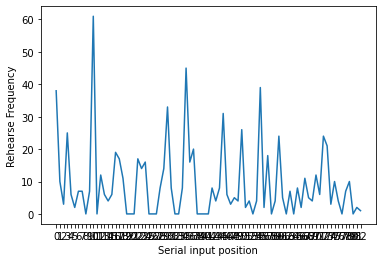

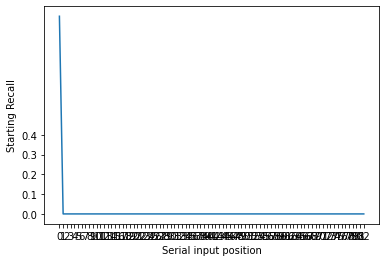

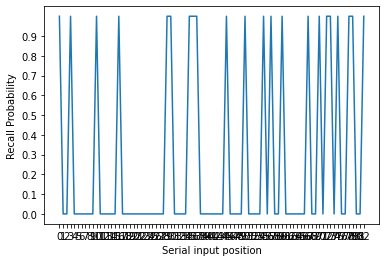

#|Warning: Chunk-type GOAL has the same specification as the chunk-type STUDY-WORDS. |#
#|Warning: No production defined for (CREATE-TOKEN =GOAL> ISA STUDY-WORDS STATE MEMORIZE TARGET =WORD =IMAGINAL ISA MEMORY WORD =WORD ==> =GOAL> ISA STUDY-WORDS STATE REHEARSE TARGET NIL). |#
#|Warning: Invalid syntax in (=GOAL> ISA STUDY-WORDS STATE MEMORIZE TARGET =WORD =IMAGINAL ISA MEMORY WORD =WORD) condition. |#
#|Warning: Invalid specs in call to define-chunk-spec - not enough arguments |#
#|Warning: Slot TARGET invalid for type STUDY-WORDS but chunk-spec definition still created. |#
#|Warning: --- end of warnings for undefined production CREATE-TOKEN --- |#
     0.000   GOAL                   SET-BUFFER-CHUNK GOAL GOAL NIL
     0.000   VISION                 PROC-DISPLAY
     0.000   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION0 NIL
     0.000   VISION                 visicon-update
     0.000   PROCEDURAL             CONFLICT-RESOLUTION
     0.000   PROCEDURAL    

     6.530   PROCEDURAL             CONFLICT-RESOLUTION
     6.530   ------                 Stopped because no events left to process
     6.530   VISION                 PROC-DISPLAY
     6.530   VISION                 visicon-update
     6.530   PROCEDURAL             CONFLICT-RESOLUTION
     6.615   VISION                 Encoding-complete VISUAL-LOCATION0-1 NIL
     6.615   VISION                 No visual-object found
     6.615   PROCEDURAL             CONFLICT-RESOLUTION
     6.615   ------                 Stopped because no events left to process
     6.615   VISION                 PROC-DISPLAY
     6.615   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION8 NIL
     6.615   VISION                 visicon-update
     6.615   PROCEDURAL             CONFLICT-RESOLUTION
     6.700   VISION                 Encoding-complete VISUAL-LOCATION0-1 NIL
     6.700   VISION                 SET-BUFFER-CHUNK VISUAL TEXT8 NIL
     6.700   PROCEDURAL             CONFLICT-RE

    11.880   PROCEDURAL             CONFLICT-RESOLUTION
    11.965   VISION                 Encoding-complete VISUAL-LOCATION0-1 NIL
    11.965   VISION                 SET-BUFFER-CHUNK VISUAL TEXT17 NIL
    11.965   PROCEDURAL             CONFLICT-RESOLUTION
    12.380   VISION                 ERASE-BUFFER VISUAL-LOCATION
    12.380   PROCEDURAL             CONFLICT-RESOLUTION
    12.380   ------                 Stopped because no events left to process
    12.380   VISION                 PROC-DISPLAY
    12.380   VISION                 visicon-update
    12.380   PROCEDURAL             CONFLICT-RESOLUTION
    12.465   VISION                 Encoding-complete VISUAL-LOCATION0-1 NIL
    12.465   VISION                 No visual-object found
    12.465   PROCEDURAL             CONFLICT-RESOLUTION
    12.465   ------                 Stopped because no events left to process
    12.465   VISION                 PROC-DISPLAY
    12.465   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATI

    17.730   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION27 NIL
    17.730   VISION                 visicon-update
    17.730   PROCEDURAL             CONFLICT-RESOLUTION
    17.815   VISION                 Encoding-complete VISUAL-LOCATION0-1 NIL
    17.815   VISION                 SET-BUFFER-CHUNK VISUAL TEXT27 NIL
    17.815   PROCEDURAL             CONFLICT-RESOLUTION
    18.230   VISION                 ERASE-BUFFER VISUAL-LOCATION
    18.230   PROCEDURAL             CONFLICT-RESOLUTION
    18.230   ------                 Stopped because no events left to process
    18.230   VISION                 PROC-DISPLAY
    18.230   VISION                 visicon-update
    18.230   PROCEDURAL             CONFLICT-RESOLUTION
    18.315   VISION                 Encoding-complete VISUAL-LOCATION0-1 NIL
    18.315   VISION                 No visual-object found
    18.315   PROCEDURAL             CONFLICT-RESOLUTION
    18.315   ------                 Stopped because

    24.165   VISION                 Encoding-complete VISUAL-LOCATION0-1 NIL
    24.165   VISION                 No visual-object found
    24.165   PROCEDURAL             CONFLICT-RESOLUTION
    24.165   ------                 Stopped because no events left to process
    24.165   VISION                 PROC-DISPLAY
    24.165   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION38 NIL
    24.165   VISION                 visicon-update
    24.165   PROCEDURAL             CONFLICT-RESOLUTION
    24.250   VISION                 Encoding-complete VISUAL-LOCATION0-1 NIL
    24.250   VISION                 SET-BUFFER-CHUNK VISUAL TEXT38 NIL
    24.250   PROCEDURAL             CONFLICT-RESOLUTION
    24.665   VISION                 ERASE-BUFFER VISUAL-LOCATION
    24.665   PROCEDURAL             CONFLICT-RESOLUTION
    24.665   ------                 Stopped because no events left to process
    24.665   VISION                 PROC-DISPLAY
    24.665   VISION            

    30.515   VISION                 visicon-update
    30.515   PROCEDURAL             CONFLICT-RESOLUTION
    30.600   VISION                 Encoding-complete VISUAL-LOCATION0-1 NIL
    30.600   VISION                 No visual-object found
    30.600   PROCEDURAL             CONFLICT-RESOLUTION
    30.600   ------                 Stopped because no events left to process
    30.600   VISION                 PROC-DISPLAY
    30.600   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION49 NIL
    30.600   VISION                 visicon-update
    30.600   PROCEDURAL             CONFLICT-RESOLUTION
    30.685   VISION                 Encoding-complete VISUAL-LOCATION0-1 NIL
    30.685   VISION                 SET-BUFFER-CHUNK VISUAL TEXT49 NIL
    30.685   PROCEDURAL             CONFLICT-RESOLUTION
    31.100   VISION                 ERASE-BUFFER VISUAL-LOCATION
    31.100   PROCEDURAL             CONFLICT-RESOLUTION
    31.100   ------                 Stopped because

    36.535   VISION                 SET-BUFFER-CHUNK VISUAL TEXT59 NIL
    36.535   PROCEDURAL             CONFLICT-RESOLUTION
    36.950   VISION                 ERASE-BUFFER VISUAL-LOCATION
    36.950   PROCEDURAL             CONFLICT-RESOLUTION
    36.950   ------                 Stopped because no events left to process
    36.950   VISION                 PROC-DISPLAY
    36.950   VISION                 visicon-update
    36.950   PROCEDURAL             CONFLICT-RESOLUTION
    37.035   VISION                 Encoding-complete VISUAL-LOCATION0-1 NIL
    37.035   VISION                 No visual-object found
    37.035   PROCEDURAL             CONFLICT-RESOLUTION
    37.035   ------                 Stopped because no events left to process
    37.035   VISION                 PROC-DISPLAY
    37.035   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION60 NIL
    37.035   VISION                 visicon-update
    37.035   PROCEDURAL             CONFLICT-RESOLUTION
 

    42.385   VISION                 Encoding-complete VISUAL-LOCATION0-1 NIL
    42.385   VISION                 SET-BUFFER-CHUNK VISUAL TEXT69 NIL
    42.385   PROCEDURAL             CONFLICT-RESOLUTION
    42.800   VISION                 ERASE-BUFFER VISUAL-LOCATION
    42.800   PROCEDURAL             CONFLICT-RESOLUTION
    42.800   ------                 Stopped because no events left to process
    42.800   VISION                 PROC-DISPLAY
    42.800   VISION                 visicon-update
    42.800   PROCEDURAL             CONFLICT-RESOLUTION
    42.885   VISION                 Encoding-complete VISUAL-LOCATION0-1 NIL
    42.885   VISION                 No visual-object found
    42.885   PROCEDURAL             CONFLICT-RESOLUTION
    42.885   ------                 Stopped because no events left to process
    42.885   VISION                 PROC-DISPLAY
    42.885   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION70 NIL
    42.885   VISION            

    48.650   VISION                 visicon-update
    48.650   PROCEDURAL             CONFLICT-RESOLUTION
    48.735   VISION                 Encoding-complete VISUAL-LOCATION0-1 NIL
    48.735   VISION                 No visual-object found
    48.735   PROCEDURAL             CONFLICT-RESOLUTION
    48.735   ------                 Stopped because no events left to process
    48.735   VISION                 PROC-DISPLAY
    48.735   VISION                 SET-BUFFER-CHUNK VISUAL-LOCATION VISUAL-LOCATION80 NIL
    48.735   VISION                 visicon-update
    48.735   PROCEDURAL             CONFLICT-RESOLUTION
    48.820   VISION                 Encoding-complete VISUAL-LOCATION0-1 NIL
    48.820   VISION                 SET-BUFFER-CHUNK VISUAL TEXT80 NIL
    48.820   PROCEDURAL             CONFLICT-RESOLUTION
    49.235   VISION                 ERASE-BUFFER VISUAL-LOCATION
    49.235   PROCEDURAL             CONFLICT-RESOLUTION
    49.235   ------                 Stopped because

   TEXT  T
TEXT16-0
   SCREEN-POS  VISUAL-LOCATION0-0
   VALUE  "neutral896"
   COLOR  BLACK
   HEIGHT  17
   WIDTH  120
   TEXT  T
TEXT15-0
   SCREEN-POS  VISUAL-LOCATION0-0
   VALUE  "positive160"
   COLOR  GREEN
   HEIGHT  17
   WIDTH  132
   TEXT  T
TEXT14-0
   SCREEN-POS  VISUAL-LOCATION0-0
   VALUE  "negative925"
   COLOR  RED
   HEIGHT  17
   WIDTH  132
   TEXT  T
TEXT13-0
   SCREEN-POS  VISUAL-LOCATION0-0
   VALUE  "positive348"
   COLOR  GREEN
   HEIGHT  17
   WIDTH  132
   TEXT  T
TEXT12-0
   SCREEN-POS  VISUAL-LOCATION0-0
   VALUE  "negative221"
   COLOR  RED
   HEIGHT  17
   WIDTH  132
   TEXT  T
TEXT11-0
   SCREEN-POS  VISUAL-LOCATION0-0
   VALUE  "positive172"
   COLOR  GREEN
   HEIGHT  17
   WIDTH  132
   TEXT  T
TEXT10-0
   SCREEN-POS  VISUAL-LOCATION0-0
   VALUE  "neutral291"
   COLOR  BLACK
   HEIGHT  17
   WIDTH  120
   TEXT  T
TEXT9-0
   SCREEN-POS  VISUAL-LOCATION0-0
   VALUE  "positive690"
   COLOR  GREEN
   HEIGHT  17
   WIDTH  132
   TEXT  T
TEXT8-0
   SCREEN-PO

In [19]:
do_experiment('controls',False,list_amount)


## Backup Reminder : DO IT!

# Here only the positions matter not the word?